# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 2/1/2025

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

##### Plate Appearances

In [4]:
complete_dataset = create_pa_inputs(multiplier_df, start_year=2013, end_year=2024, short=50, long=300, adjust=True, generate=False, write=False)

##### Steamer

In [5]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [6]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [7]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 2.12 s
Wall time: 2.14 s


##### Steamer

Clean

In [8]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [9]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [10]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [11]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [12]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [13]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [14]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [15]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [16]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [17]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter', 
    direction='backward'
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',
    direction='backward'
)

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

First, remove from dataset if ever missing FG/Steamer stats

In [18]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [19]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: 0s

In [20]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [21]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [22]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [23]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [24]:
batter_input_list = batter_inputs

Pitcher Inputs

In [25]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [26]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [27]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [28]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [29]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [30]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [31]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [32]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [33]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [34]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [35]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [36]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [37]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [38]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [39]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [40]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id"]

Multiplier Inputs

In [41]:
for event in events_list:
    # Assign multiplier for their 
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], complete_merged_df[f'{event}_wfx_r'])

In [42]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Inputs

In [43]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [44]:
output_list = ['is_out', 'eventsModel']

Other variables

In [45]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [46]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance, so we need to shift.

##### Batter Inputs

Sort

In [47]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [48]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [49]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [50]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [51]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [52]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [53]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [54]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### Model Dataset

Create Model Dataset

In [55]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [56]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df,  batter_predictions, pitcher_predictions

In [57]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [58]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [59]:
training_mask = (model_dataset['split'] == 0)
out_mask = (model_dataset['is_out'] == 1)

### Binary

In [60]:
binary_stat_list = []

##### Settings

In [61]:
%%time
# Neural network layers
# layers = (5,)
layers = (n1,4)
# layers = (196,196,196,196,196,196)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
max_iter = 1000
alpha = 0.0001
learning_rate = 0.00001
batch_size='auto'
# batch_size=16
random_state = random.randint(1,99999)
print(random_state)
num_models = 10
cv = 1 # Unused
n_jobs = -1

binary_filename = f"predict_binary_{layers_str}_{todaysdate}.sav"
print(binary_filename)

14420
predict_binary_1954_20250307.sav
CPU times: total: 0 ns
Wall time: 2.17 ms


In [62]:
model_list = [(n1,4), (5,), (n1,8,4)]

##### Loop

predict_binary_1954_14420_20250307.sav
   Year                                    File    Layers  Models  State  \
0   All  predict_binary_1954_14420_20250307.sav  (195, 4)      50  14420   
1  2024  predict_binary_1954_14420_20250307.sav  (195, 4)      50  14420   

    Actual Predicted Multiplier Std. Dev      MSE  
0 0.680782  0.680627   1.000228 0.042694 0.000274  
1 0.688004  0.684441   1.005206 0.040837 0.000527  


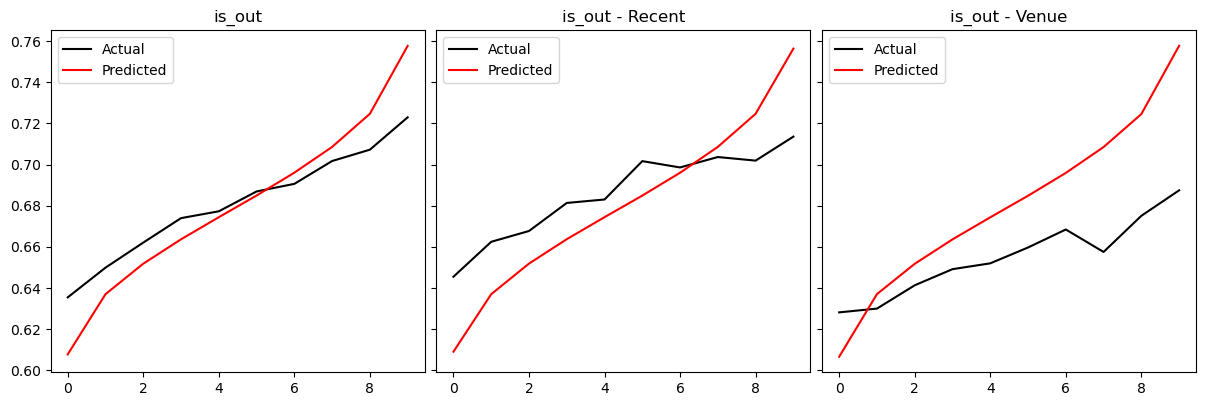

predict_binary_1954_14421_20250307.sav
   Year                                    File    Layers  Models  State  \
0   All  predict_binary_1954_14421_20250307.sav  (195, 4)      50  14421   
1  2024  predict_binary_1954_14421_20250307.sav  (195, 4)      50  14421   

    Actual Predicted Multiplier Std. Dev      MSE  
0 0.680782  0.680849   0.999902 0.045836 0.000196  
1 0.688004  0.686883   1.001632 0.044095 0.000288  


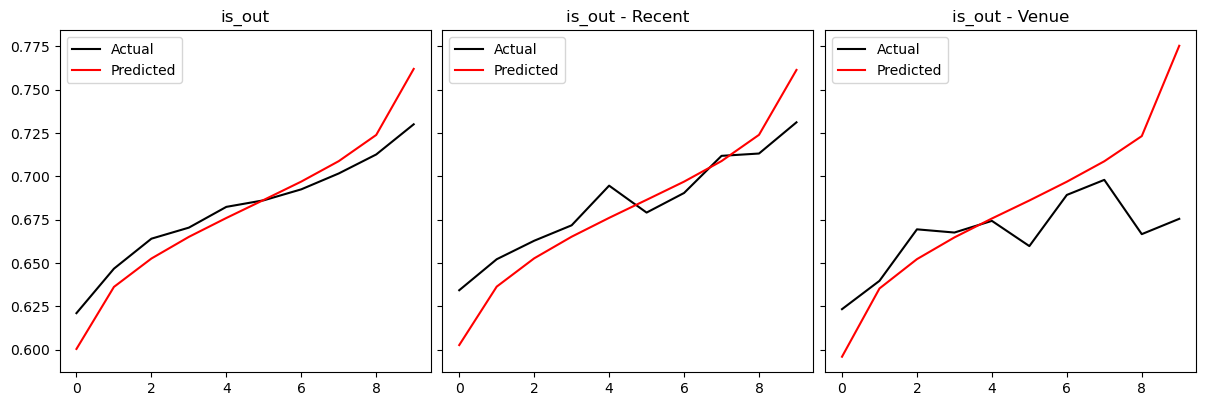

predict_binary_1954_14422_20250307.sav
   Year                                    File    Layers  Models  State  \
0   All  predict_binary_1954_14422_20250307.sav  (195, 4)      50  14422   
1  2024  predict_binary_1954_14422_20250307.sav  (195, 4)      50  14422   

    Actual Predicted Multiplier Std. Dev      MSE  
0 0.680782  0.683740   0.995674 0.033495 0.000169  
1 0.688004  0.687678   1.000474 0.034440 0.000285  


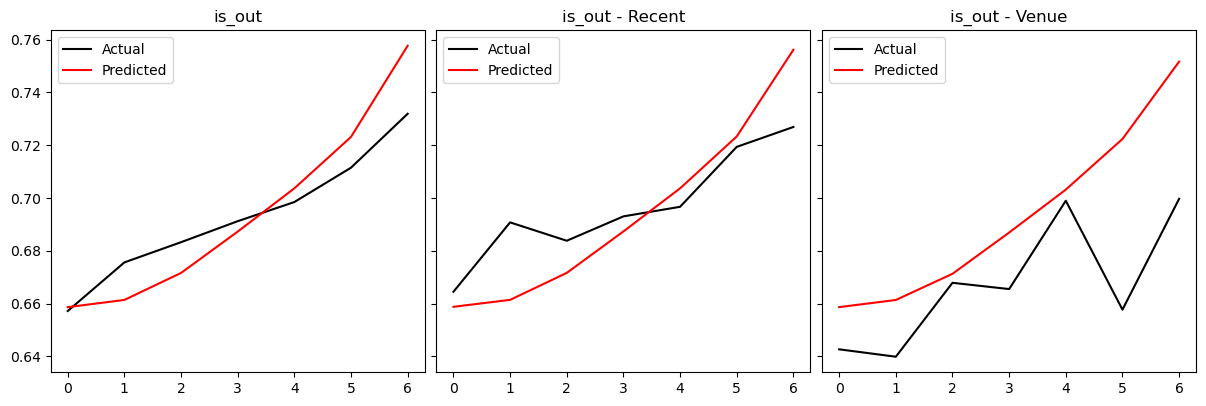

predict_binary_1954_14423_20250307.sav
   Year                                    File    Layers  Models  State  \
0   All  predict_binary_1954_14423_20250307.sav  (195, 4)      50  14423   
1  2024  predict_binary_1954_14423_20250307.sav  (195, 4)      50  14423   

    Actual Predicted Multiplier Std. Dev      MSE  
0 0.680782  0.678555   1.003282 0.044310 0.000193  
1 0.688004  0.684167   1.005608 0.042602 0.000303  


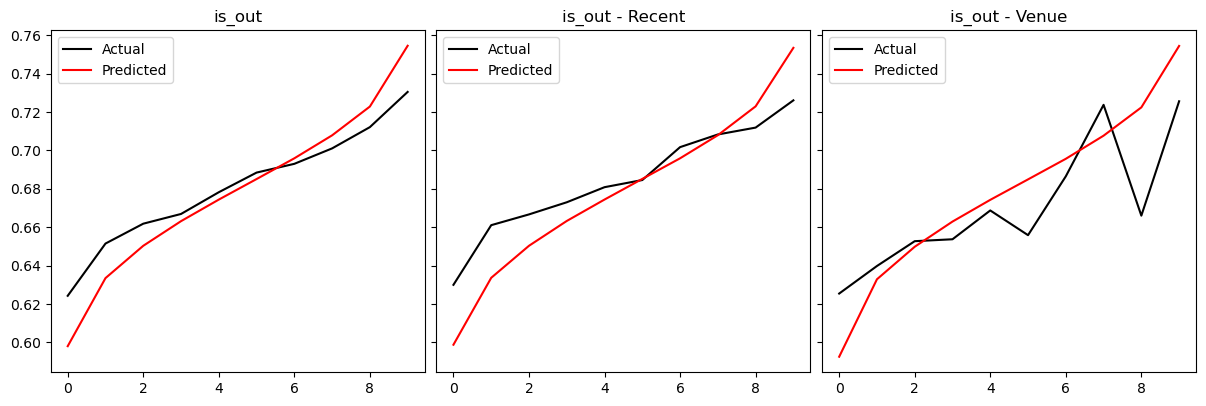

predict_binary_1954_14424_20250307.sav
   Year                                    File    Layers  Models  State  \
0   All  predict_binary_1954_14424_20250307.sav  (195, 4)      50  14424   
1  2024  predict_binary_1954_14424_20250307.sav  (195, 4)      50  14424   

    Actual Predicted Multiplier Std. Dev      MSE  
0 0.680782  0.675875   1.007260 0.051465 0.000845  
1 0.688004  0.684517   1.005094 0.051812 0.001309  


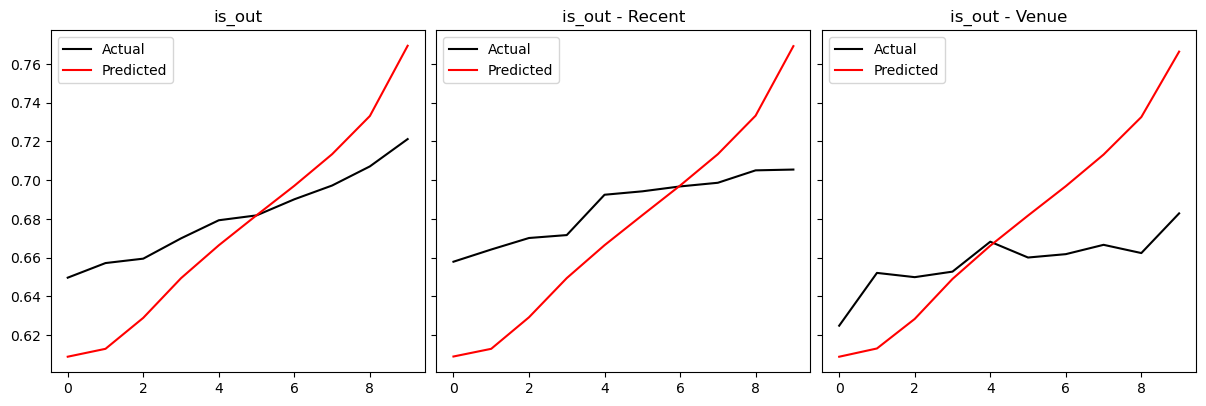

predict_binary_1954_14425_20250307.sav


In [ ]:
%%time
for layers in model_list:
    layers_str = ''.join(str(x) for x in layers)
    for i in range(num_models):
        # Set filename
        binary_filename = f"predict_binary_{layers_str}_{random_state+i}_{todaysdate}.sav"   
        print(binary_filename)
        
        # Create Model
        predict_binary = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=False, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=max_iter, batch_size=batch_size)
    
        # Fit
        predict_binary.fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['is_out']].values.ravel())
    
        # Save model
        pickle.dump(predict_binary, open(os.path.join(model_path, "M03. Plate Appearances", binary_filename), 'wb'))
    
        # Predict
        all_outputs = list(predict_binary.classes_)
        all_outputs_pred = ["is_safe_pred", "is_out_pred"]
        
        model_dataset.loc[~training_mask, all_outputs_pred] = predict_binary.predict_proba(model_dataset[~training_mask][input_list])
    
        # Set quantiles
        quantiles = 10
        
        # Create quantiles
        for var in ['is_out']:    
            # Create actual outcome column
            model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)
        
            # Create actual is_out value
            if var == "is_out":
                model_dataset.loc[~training_mask, f'{var}_act'] = model_dataset.loc[~training_mask, 'eventsModel'].isin(['so', 'lo', 'po', 'go', 'fo']).astype(int)
            
            # Create deciles
            model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, duplicates='drop', labels=False)
            
            # Create aggregated dataframe
            globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
            globals()[f"{var}_year_df"] = model_dataset.query('year >= 2024').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
            globals()[f"{var}_venue_df"] = model_dataset.query('venue_id == 19').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
        # Calculate stats
        var = "is_out"
        year = 2024
        
        # All
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", actual, predicted, mult, stdev, mse])
        
        # Year
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), actual, predicted, mult, stdev, mse])
        
        # DataFrame
        binary_stat_df = pd.concat([all_df, recent_df], axis=1).T.reset_index(drop=True)
        binary_stat_df.columns = ['Year', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
        binary_stat_df['Layers'] = str(layers)
        binary_stat_df['Models'] = num_models
        binary_stat_df['State'] = random_state+i
        binary_stat_df['File'] = binary_filename
        binary_stat_df = binary_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]
    
        print(binary_stat_df)
        
        # Create figure and 3 subplots (1 row, 3 columns)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
        
        var = "is_out"
        
        # List of dataframes to plot
        df_list = [globals()[f"{var}_df"], globals()[f"{var}_year_df"], globals()[f"{var}_venue_df"]]
        titles = [var, f"{var} - Recent", f"{var} - Venue"]
        
        # Loop through and plot each dataframe on separate axes
        for ax, df, title in zip(axes, df_list, titles):
            ax.plot(df[f'{var}_quantile'], df[f'{var}_act'], color='black', label="Actual")
            ax.plot(df[f'{var}_quantile'], df[f'{var}_pred'], color='red', label="Predicted")
            ax.set_title(title)
            ax.legend()
        
        # Adjust layout
        fig.tight_layout(pad=0.5)
        
        # Show figure
        plt.show()
        
        binary_stat_list.append(binary_stat_df)

##### Stats

In [ ]:
binary_stats = pd.concat(binary_stat_list, axis=0)

In [ ]:
pareto_front = pareto_optimal(binary_stats.query("Year == '2024'"), 
                              ['MSE', 'Std. Dev'], 
                              ['Minimize', 'Maximize'])
pareto_front[(pareto_front['Multiplier'] < 1.001) & (pareto_front['Multiplier'] > 0.999)].sort_values('Std. Dev')

##### Voting

##### Select Models

In [ ]:
selected_binary_filename_list = [
                                 "predict_binary_3901954_3573_20250226.sav",
                                 "predict_binary_3901954_3575_20250226.sav"
                                ]

In [ ]:
%%time
# Load models from the file paths
models = [(filename.split('.')[0], pickle.load(open(os.path.join(model_path, "M03. Plate Appearances", filename), 'rb')))
          for filename in selected_binary_filename_list]

# Create the VotingClassifier
predict_binary_voting = VotingClassifier(
    estimators=models,
    voting='soft'
)

# Fit the VotingClassifier on the entire training set
predict_binary_voting.fit(model_dataset[training_mask][input_list], model_dataset[training_mask]['is_out'])

binary_voting_filename = f"predict_binary_voting_{layers_str}_{todaysdate}.sav"   
print(binary_voting_filename)
# Save model
pickle.dump(predict_binary_voting, open(os.path.join(model_path, "M03. Plate Appearances", binary_voting_filename), 'wb'))

##### Predict

In [ ]:
all_outputs = list(predict_binary.classes_)
all_outputs_pred = ["is_safe_pred", "is_out_pred"]

model_dataset.loc[~training_mask, all_outputs_pred] = predict_binary_voting.predict_proba(model_dataset[~training_mask][input_list])

##### Quantiles

In [ ]:
# Set quantiles
quantiles = 10

# Create quantiles
for var in ['is_out']:    
    # Create actual outcome column
    model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)

    # Create actual is_out value
    if var == "is_out":
        model_dataset.loc[~training_mask, f'{var}_act'] = model_dataset.loc[~training_mask, 'eventsModel'].isin(['so', 'lo', 'po', 'go', 'fo']).astype(int)
    
    # Create deciles
    model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False)
    
    # Create aggregated dataframe
    globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_year_df"] = model_dataset.query('year >= 2024').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[f"{var}_venue_df"] = model_dataset.query('venue_id == 19').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

##### Graph

In [ ]:
# Create figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

var = "is_out"

# List of dataframes to plot
df_list = [globals()[f"{var}_df"], globals()[f"{var}_year_df"], globals()[f"{var}_venue_df"]]
titles = [var, f"{var} - Recent", f"{var} - Venue"]

# Loop through and plot each dataframe on separate axes
for ax, df, title in zip(axes, df_list, titles):
    ax.plot(df[f'{var}_quantile'], df[f'{var}_act'], color='black', label="Actual")
    ax.plot(df[f'{var}_quantile'], df[f'{var}_pred'], color='red', label="Predicted")
    ax.set_title(title)
    ax.legend()

# Adjust layout
fig.tight_layout(pad=0.5)

# Show figure
plt.show()

##### Stats

In [ ]:
var = "is_out"
year = 2024

# All
actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
mult = actual/predicted
stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
# globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index() # graphing all, delete these
globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
mse = globals()[f"{var}_df"]['se'].mean()
all_df = pd.DataFrame(["All", actual, predicted, mult, stdev, mse])

# Year
actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
mult = actual/predicted
stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
# globals()[f"{var}_year_df"] = model_dataset.query('year >= 2024').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
mse = globals()[f"{var}_year_df"]['se'].mean()
recent_df = pd.DataFrame([str(int(year)), actual, predicted, mult, stdev, mse])

# DataFrame
binary_stat_df = pd.concat([all_df, recent_df], axis=1).T.reset_index(drop=True)
binary_stat_df.columns = ['Year', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
binary_stat_df['Layers'] = str(layers)
binary_stat_df['Models'] = num_models
binary_stat_df['State'] = random_state
binary_stat_df[['Year', 'Layers', 'Models', 'State', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

### Outs

In [ ]:
out_stat_list = []

##### Settings

In [ ]:
%%time
# Neural network layers
# layers = (n1,n1)
layers = (10,)
# layers = (196,196,196,196,196,196)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
max_iter = 1000
alpha = 0.0001
learning_rate = 0.00001
batch_size='auto'
random_state = random.randint(1,99999)
print(random_state)
num_models = 5
cv = 1 # Unused
n_jobs = -1

outs_filename = f"predict_outs_{layers_str}_{todaysdate}.sav"
print(outs_filename)

##### Loop

In [ ]:
%%time
for i in range(num_models):
    # Set filename
    outs_filename = f"predict_outs_{layers_str}_{random_state+i}_{todaysdate}.sav"
    print(outs_filename)

    # Create Model
    predict_outs = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=False, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=max_iter, batch_size=batch_size)

    # Fit
    predict_outs.fit(model_dataset[training_mask][out_mask][input_list], model_dataset[training_mask][out_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_outs, open(os.path.join(model_path, "M03. Plate Appearances", outs_filename), 'wb'))

    # Predict out types
    outs_outputs = list(predict_outs.classes_)
    outs_outputs_pred = [x + "_pred" for x in outs_outputs]
    
    model_dataset.loc[~training_mask & out_mask, outs_outputs_pred] = predict_outs.predict_proba(model_dataset[~training_mask][out_mask][input_list])

    # FP
    model_dataset.loc[~training_mask & out_mask, 'FP_act'] = (
        (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == "fo").astype(int) * 0.2534 +
        (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == "go").astype(int) * 0.2534 +
        (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == "po").astype(int) * 0.2534 +
        (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == "lo").astype(int) * 0.2534 +
        (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == "so").astype(int) * 2.4866
    )

    model_dataset.loc[~training_mask & out_mask, 'FP_pred'] = (model_dataset[~training_mask][out_mask]['fo_pred'] * 0.2534 +
                                                               model_dataset[~training_mask][out_mask]['go_pred'] * 0.2534 +
                                                               model_dataset[~training_mask][out_mask]['po_pred'] * 0.2534 + 
                                                               model_dataset[~training_mask][out_mask]['lo_pred'] * 0.2534 +
                                                               model_dataset[~training_mask][out_mask]['so_pred'] * 2.4866)
                                        
    # Quantiles
    year = 2022
    venue = 19
    
    for var in outs_outputs:
        # Create actual outcome column
        model_dataset.loc[~training_mask & out_mask, f'{var}_act'] = (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask & out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & out_mask, f'{var}_pred'], 10, labels=False)
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    for var in ['FP']:
        # # Create actual outcome column
        # model_dataset.loc[~training_mask & out_mask, f'{var}_act'] = (model_dataset.loc[~training_mask & out_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask & out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & out_mask, f'{var}_pred'], 10, labels=False)
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

    # All
    all_df_list = []
    for var in outs_outputs + ['FP']:
        actual = model_dataset.loc[~training_mask & out_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask & out_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask & out_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    # Year
    recent_df_list = []
    for var in outs_outputs + ['FP']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask & out_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask & out_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask & out_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    # DataFrame
    out_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    out_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    out_stat_df['File'] = outs_filename
    out_stat_df['Layers'] = str(layers)
    out_stat_df['Models'] = num_models
    out_stat_df['State'] = random_state+i
    out_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(out_stat_df)
    
    out_stat_list.append(out_stat_df)
    
    graph_options = ["", "_year", "_venue"]
    graph_index = 0
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")
    
    # Create figures
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    for i, var in enumerate(outs_outputs + ['FP']):
        row = i // 3  # Calculate the row index based on the iteration
        col = i % 3   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
        # axs[row, col].set_ylim(0,0.35)
    
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

##### Evaluate

Create evaluations dataframe

In [ ]:
all_out_stat_df = pd.concat(out_stat_list)
all_out_stat_df = all_out_stat_df.reset_index(drop=True)

Identify pareto-optimal models

In [ ]:
subset = all_out_stat_df.query('Year == "2022"').query('Output == "FP"').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

### Safe

In [63]:
safe_stat_list = []

##### Settings

In [70]:
%%time
# layers = (10,5)
layers = (n1,10)
layers_str = ''.join(str(x) for x in layers)
activation = 'relu'
max_iter = 100
alpha = 0.0001
learning_rate = 0.00001
batch_size=8
random_state = random.randint(1,99999)
print(random_state)
# random_state = 95835
num_models = 20

48766
CPU times: total: 0 ns
Wall time: 0 ns


##### Loop

predict_safe_19510_48766_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.451734   0.995502 0.091046 0.000071   
1    All     b2 0.139234  0.140773   0.989065 0.033881 0.000283   
2    All     b3 0.013203  0.013149   1.004133 0.006126 0.000014   
3    All     bb 0.264014  0.267012   0.988772 0.085739 0.000034   
4    All    hbp 0.034034  0.032183   1.057527 0.012463 0.000010   
5    All     hr 0.099813  0.095150   1.049011 0.043108 0.000055   
6    All     FP 5.439955  5.390702   1.009137 0.520460 0.009835   
7   2024     b1 0.453367  0.460035   0.985506 0.089086 0.000247   
8   2024     b2 0.137402  0.139556   0.984566 0.032296 0.000233   
9   2024     b3 0.012906  0.012740   1.013044 0.006246 0.000022   
10  2024     bb 0.262959  0.262599   1.001374 0.083399 0.000203   
11  2024    hbp 0.037444  0.031193   1.200424 0.012687 0.000079   
12  2024     hr 0.095921  0.093878   1.021764 0.040827 0.000160   
13  2024     FP 5.387913

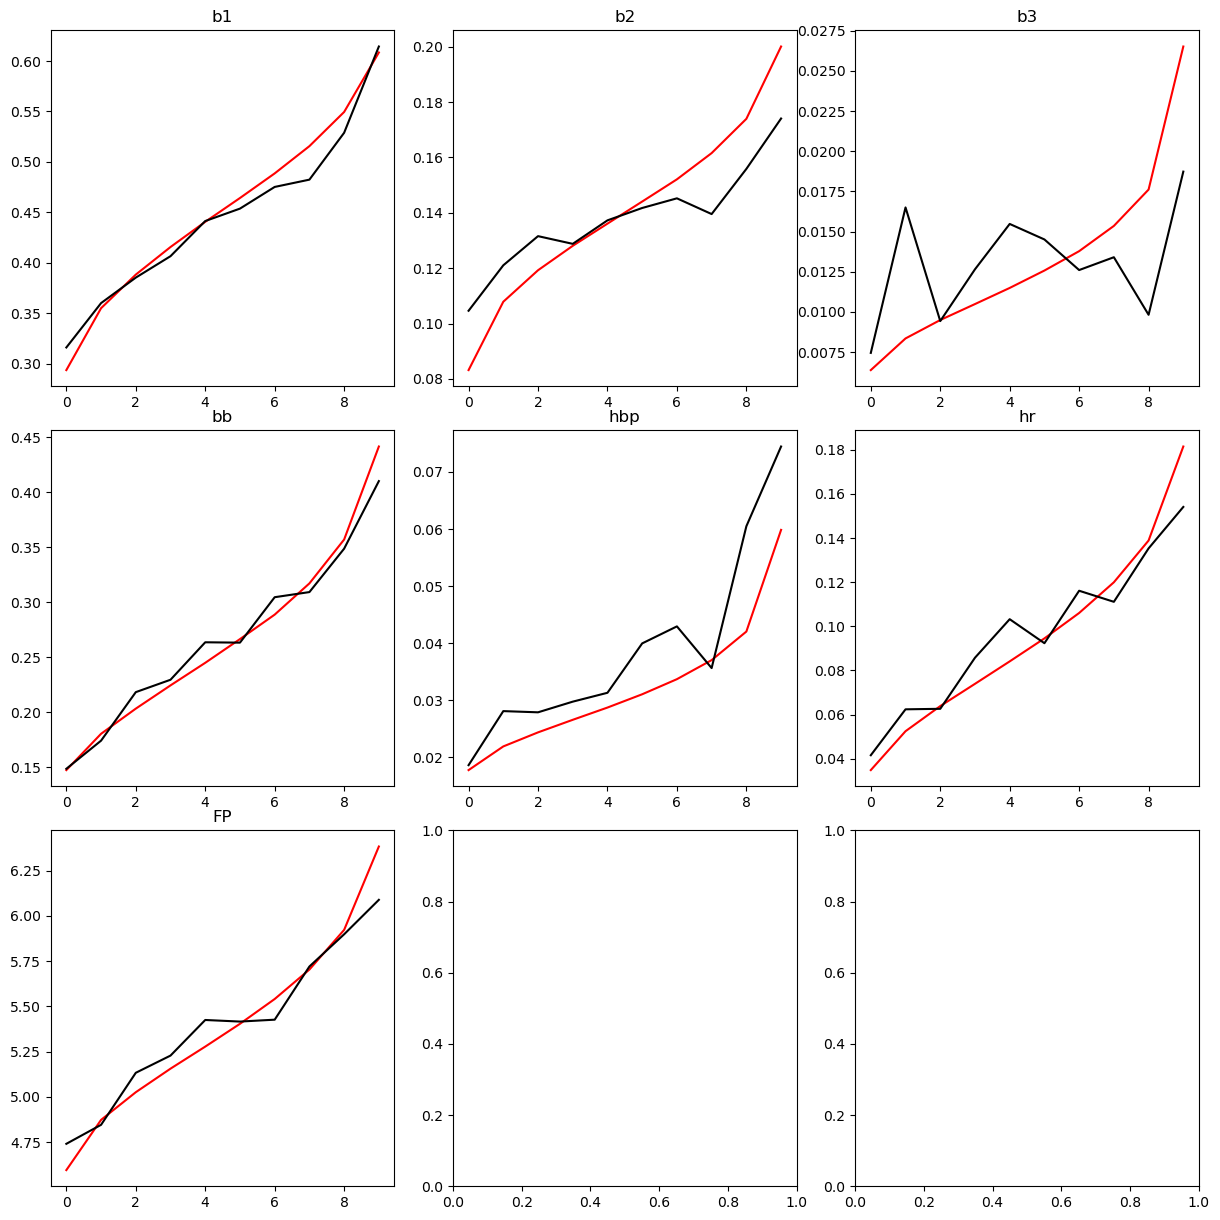

predict_safe_19510_48767_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.448997   1.001569 0.088530 0.000056   
1    All     b2 0.139234  0.142511   0.977006 0.022887 0.000080   
2    All     b3 0.013203  0.013450   0.981675 0.005761 0.000004   
3    All     bb 0.264014  0.259987   1.015490 0.083566 0.000045   
4    All    hbp 0.034034  0.032787   1.038048 0.009728 0.000009   
5    All     hr 0.099813  0.102269   0.975987 0.039278 0.000021   
6    All     FP 5.439955  5.484137   0.991944 0.448976 0.004856   
7   2024     b1 0.453367  0.453297   1.000156 0.084863 0.000134   
8   2024     b2 0.137402  0.143426   0.957996 0.023033 0.000170   
9   2024     b3 0.012906  0.012881   1.001971 0.005458 0.000010   
10  2024     bb 0.262959  0.255249   1.030208 0.080299 0.000199   
11  2024    hbp 0.037444  0.031947   1.172084 0.009653 0.000074   
12  2024     hr 0.095921  0.103201   0.929460 0.038146 0.000138   
13  2024     FP 5.387913

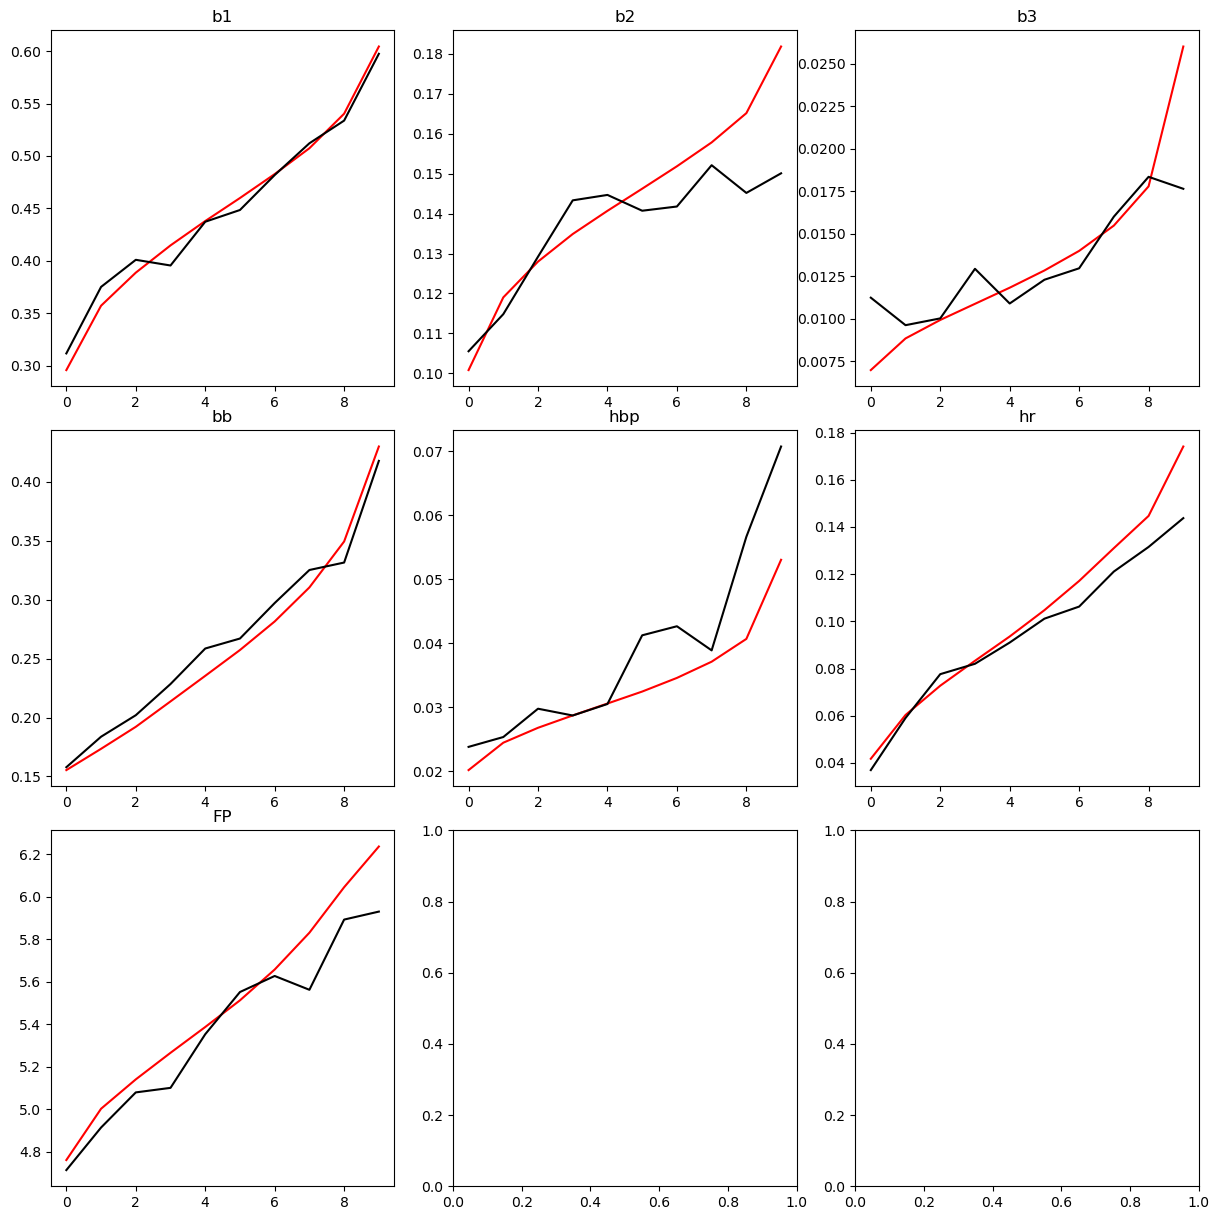

predict_safe_19510_48768_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.455409   0.987469 0.094856 0.000199   
1    All     b2 0.139234  0.140400   0.991695 0.029745 0.000132   
2    All     b3 0.013203  0.012479   1.058051 0.007923 0.000006   
3    All     bb 0.264014  0.257961   1.023464 0.093258 0.000169   
4    All    hbp 0.034034  0.032158   1.058327 0.015893 0.000010   
5    All     hr 0.099813  0.101593   0.982477 0.045692 0.000071   
6    All     FP 5.439955  5.469195   0.994654 0.545929 0.013067   
7   2024     b1 0.453367  0.461979   0.981358 0.091900 0.000459   
8   2024     b2 0.137402  0.139112   0.987707 0.029213 0.000250   
9   2024     b3 0.012906  0.012002   1.075377 0.008211 0.000007   
10  2024     bb 0.262959  0.254789   1.032068 0.088961 0.000345   
11  2024    hbp 0.037444  0.032777   1.142410 0.016866 0.000036   
12  2024     hr 0.095921  0.099342   0.965565 0.043631 0.000296   
13  2024     FP 5.387913

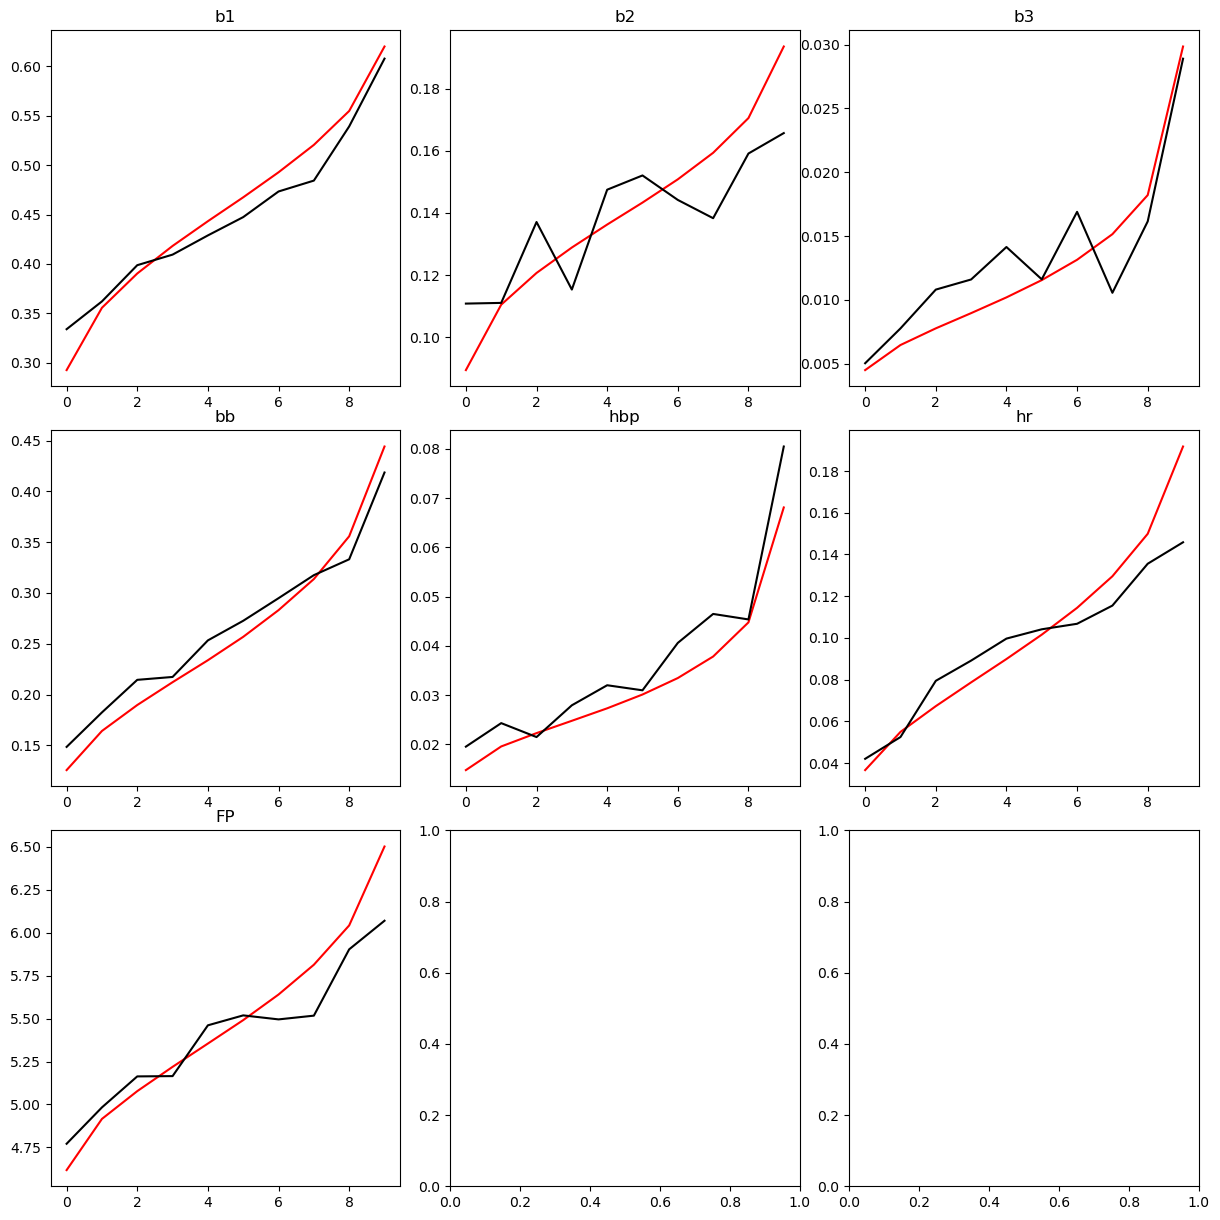

predict_safe_19510_48769_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.465515   0.966031 0.094738 0.000457   
1    All     b2 0.139234  0.135369   1.028556 0.024540 0.000244   
2    All     b3 0.013203  0.013002   1.015499 0.009484 0.000035   
3    All     bb 0.264014  0.254355   1.037973 0.082671 0.000113   
4    All    hbp 0.034034  0.030820   1.104272 0.009791 0.000016   
5    All     hr 0.099813  0.100939   0.988842 0.044759 0.000099   
6    All     FP 5.439955  5.460344   0.996266 0.505079 0.010027   
7   2024     b1 0.453367  0.471398   0.961751 0.091826 0.000656   
8   2024     b2 0.137402  0.135881   1.011190 0.024200 0.000231   
9   2024     b3 0.012906  0.012281   1.050921 0.009228 0.000027   
10  2024     bb 0.262959  0.250630   1.049196 0.079666 0.000250   
11  2024    hbp 0.037444  0.030674   1.220712 0.010209 0.000060   
12  2024     hr 0.095921  0.099137   0.967564 0.042466 0.000348   
13  2024     FP 5.387913

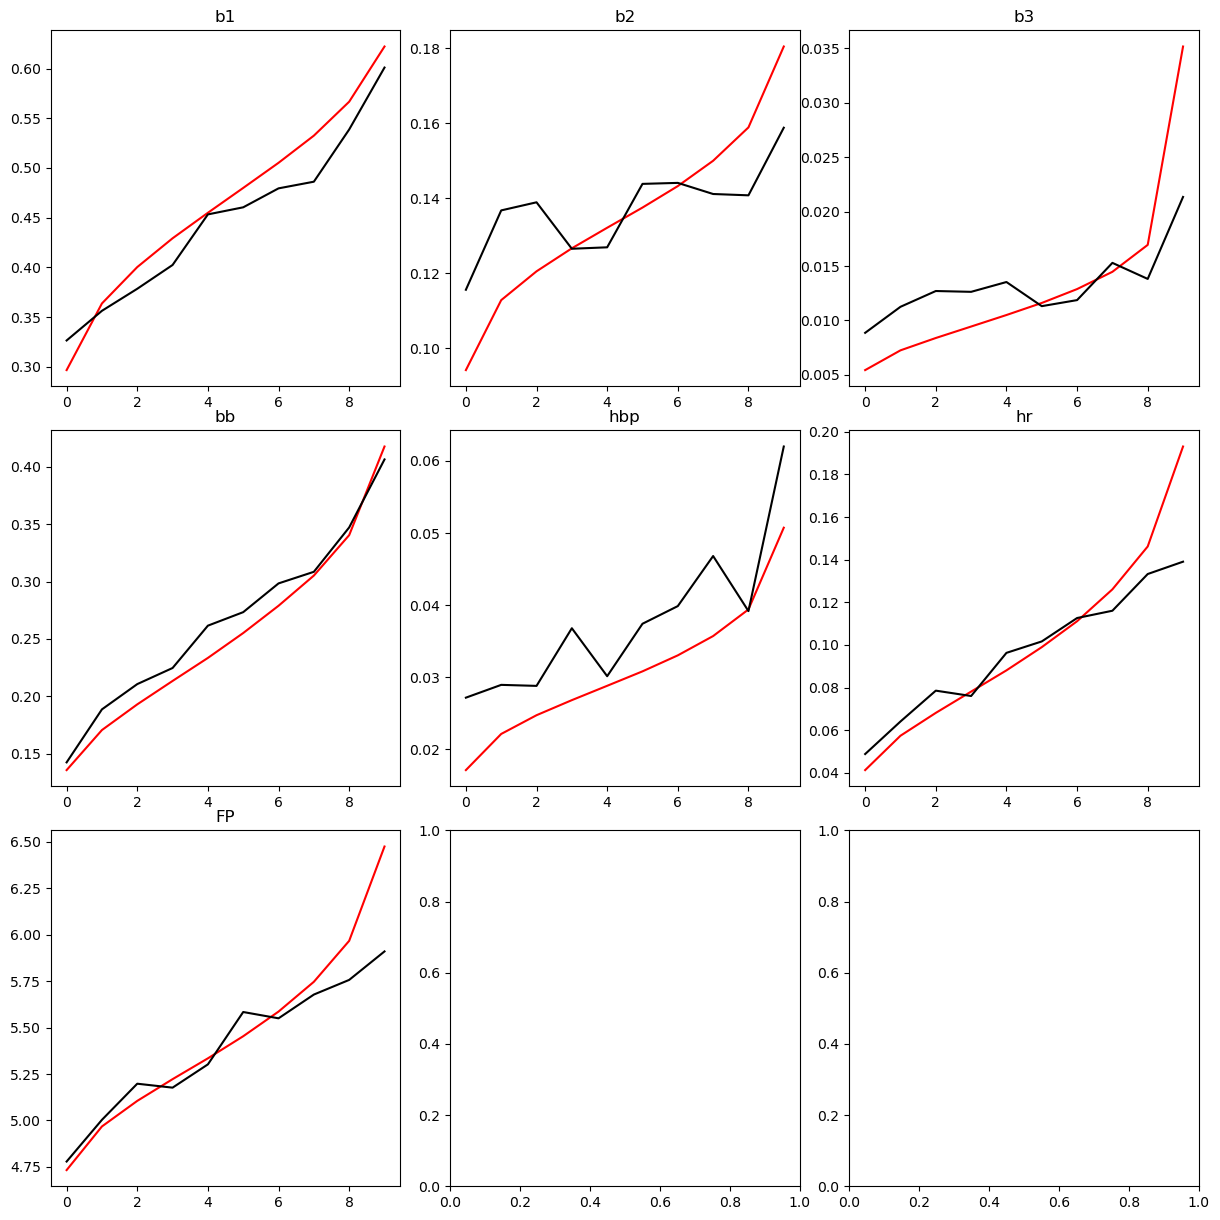

predict_safe_19510_48770_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.451579   0.995842 0.092164 0.000125   
1    All     b2 0.139234  0.137206   1.014784 0.035769 0.000335   
2    All     b3 0.013203  0.012500   1.056233 0.006305 0.000003   
3    All     bb 0.264014  0.267082   0.988512 0.085430 0.000036   
4    All    hbp 0.034034  0.031426   1.082995 0.016948 0.000009   
5    All     hr 0.099813  0.100207   0.996070 0.036881 0.000016   
6    All     FP 5.439955  5.433770   1.001138 0.461930 0.001451   
7   2024     b1 0.453367  0.458675   0.988429 0.089874 0.000401   
8   2024     b2 0.137402  0.135875   1.011237 0.033813 0.000341   
9   2024     b3 0.012906  0.011796   1.094082 0.005755 0.000014   
10  2024     bb 0.262959  0.263884   0.996495 0.084754 0.000278   
11  2024    hbp 0.037444  0.031076   1.204913 0.017890 0.000053   
12  2024     hr 0.095921  0.098693   0.971911 0.034590 0.000097   
13  2024     FP 5.387913

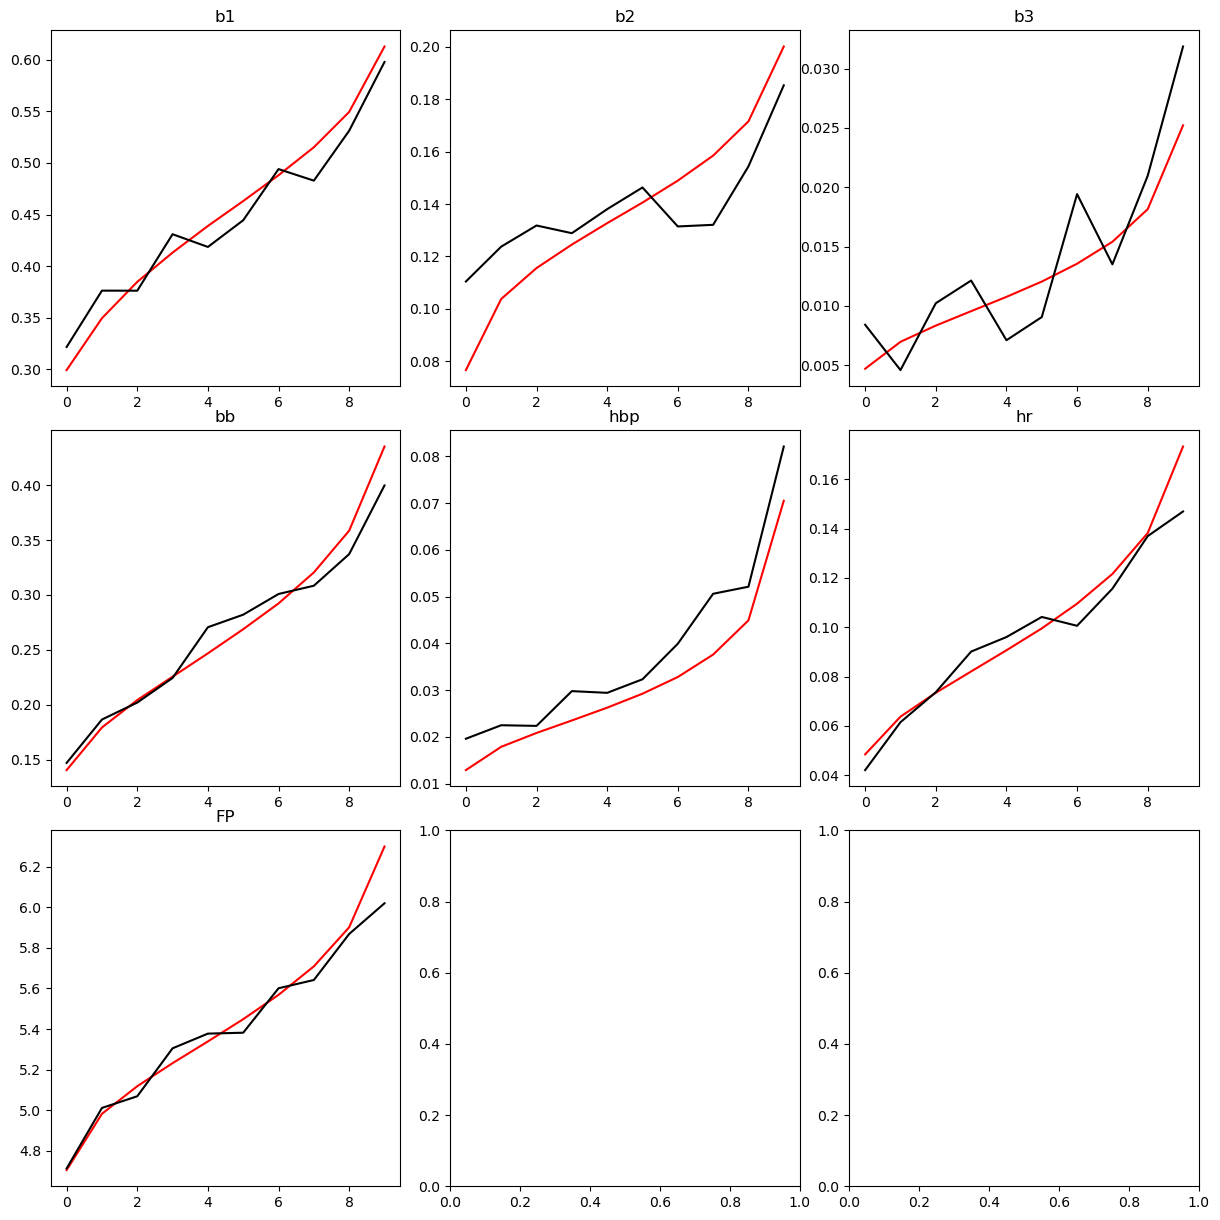

predict_safe_19510_48771_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.460065   0.977474 0.093524 0.000226   
1    All     b2 0.139234  0.138920   1.002258 0.022293 0.000055   
2    All     b3 0.013203  0.013731   0.961571 0.008031 0.000012   
3    All     bb 0.264014  0.254918   1.035682 0.085767 0.000101   
4    All    hbp 0.034034  0.031857   1.068358 0.014313 0.000007   
5    All     hr 0.099813  0.100509   0.993075 0.043288 0.000030   
6    All     FP 5.439955  5.466831   0.995084 0.510158 0.004867   
7   2024     b1 0.453367  0.467227   0.970336 0.090448 0.000446   
8   2024     b2 0.137402  0.136139   1.009276 0.022186 0.000156   
9   2024     b3 0.012906  0.013101   0.985160 0.007977 0.000021   
10  2024     bb 0.262959  0.252510   1.041381 0.083072 0.000242   
11  2024    hbp 0.037444  0.031953   1.171859 0.014742 0.000064   
12  2024     hr 0.095921  0.099070   0.968214 0.041208 0.000245   
13  2024     FP 5.387913

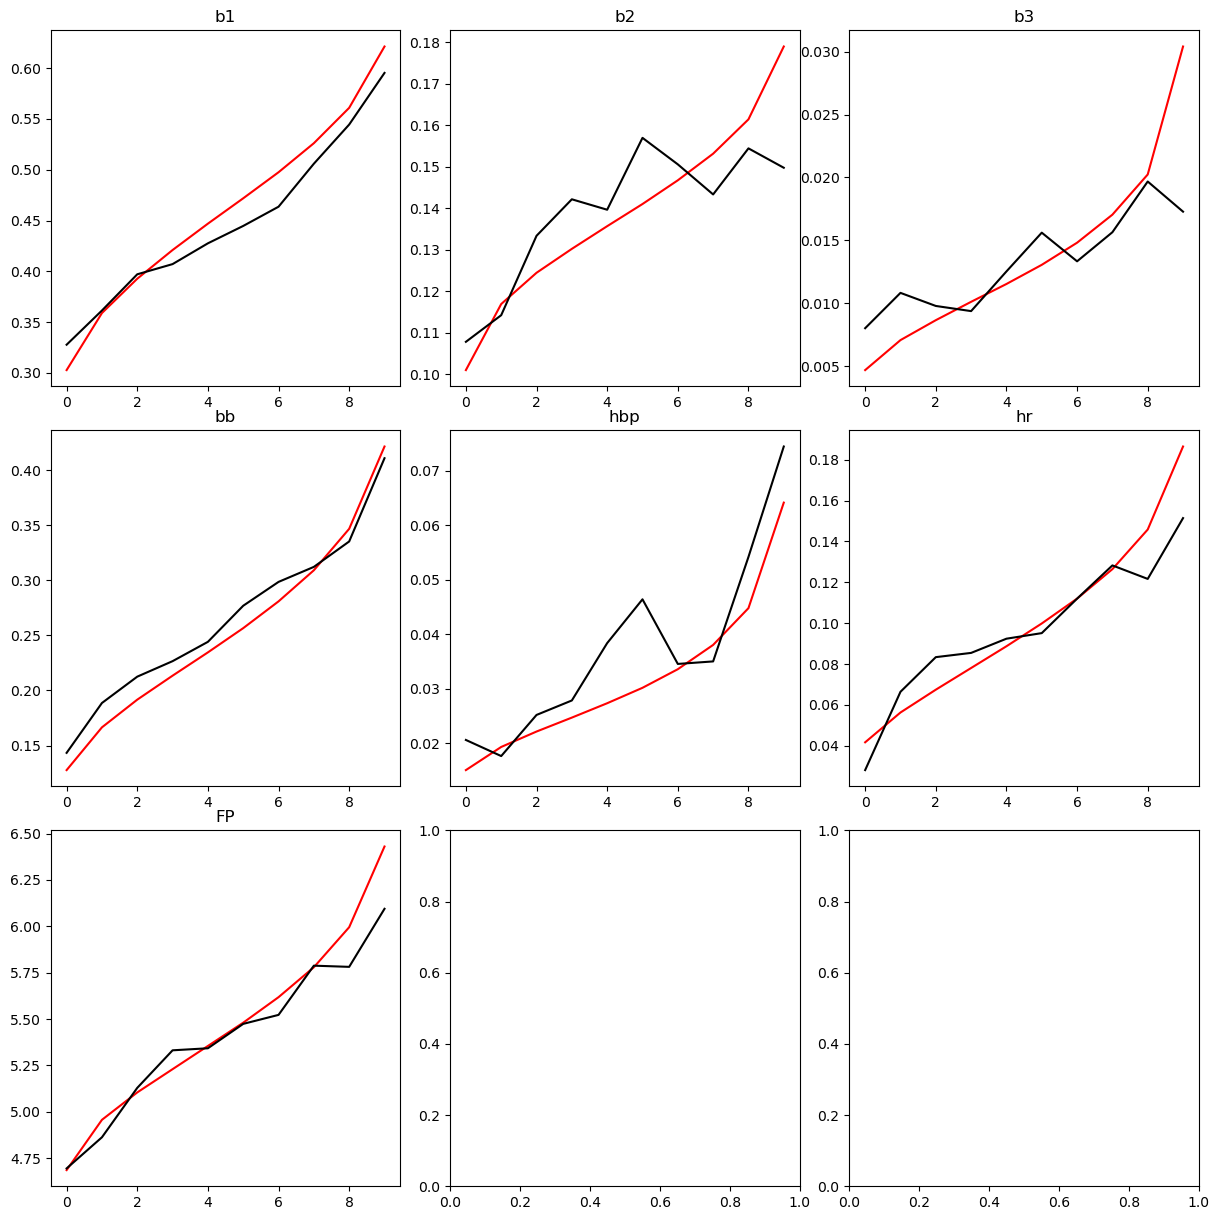

predict_safe_19510_48772_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.450111   0.999091 0.095467 0.000140   
1    All     b2 0.139234  0.139374   0.998993 0.024664 0.000049   
2    All     b3 0.013203  0.012807   1.030957 0.006180 0.000002   
3    All     bb 0.264014  0.264331   0.998799 0.092944 0.000112   
4    All    hbp 0.034034  0.032165   1.058120 0.017768 0.000007   
5    All     hr 0.099813  0.101212   0.986178 0.048652 0.000129   
6    All     FP 5.439955  5.455118   0.997220 0.569360 0.017138   
7   2024     b1 0.453367  0.456640   0.992832 0.092747 0.000239   
8   2024     b2 0.137402  0.139392   0.985721 0.024551 0.000119   
9   2024     b3 0.012906  0.011521   1.120261 0.005526 0.000006   
10  2024     bb 0.262959  0.260405   1.009810 0.090032 0.000315   
11  2024    hbp 0.037444  0.032727   1.144146 0.018347 0.000035   
12  2024     hr 0.095921  0.099315   0.965827 0.045925 0.000331   
13  2024     FP 5.387913

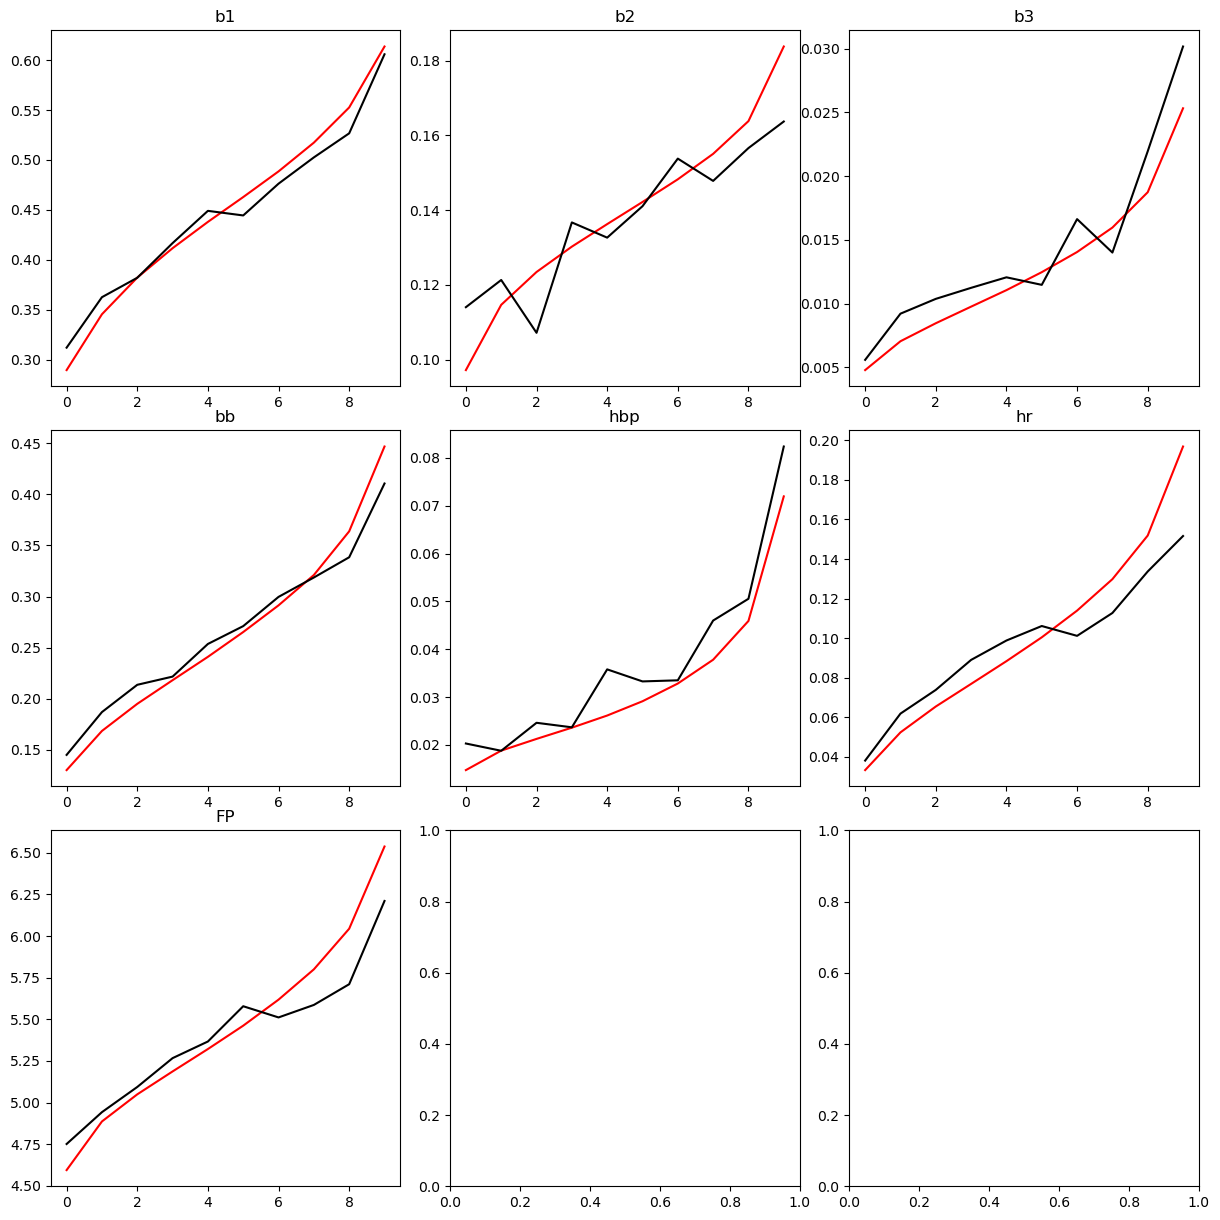

predict_safe_19510_48773_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.454196   0.990105 0.096033 0.000208   
1    All     b2 0.139234  0.139291   0.999588 0.032932 0.000261   
2    All     b3 0.013203  0.013711   0.962966 0.007006 0.000019   
3    All     bb 0.264014  0.262131   1.007184 0.090031 0.000076   
4    All    hbp 0.034034  0.032545   1.045761 0.014673 0.000005   
5    All     hr 0.099813  0.098126   1.017196 0.041468 0.000033   
6    All     FP 5.439955  5.429907   1.001850 0.482162 0.003407   
7   2024     b1 0.453367  0.459420   0.986826 0.094846 0.000528   
8   2024     b2 0.137402  0.138620   0.991211 0.032153 0.000404   
9   2024     b3 0.012906  0.013706   0.941652 0.006785 0.000026   
10  2024     bb 0.262959  0.258758   1.016237 0.087571 0.000326   
11  2024    hbp 0.037444  0.032484   1.152697 0.014780 0.000036   
12  2024     hr 0.095921  0.097012   0.988752 0.040315 0.000172   
13  2024     FP 5.387913

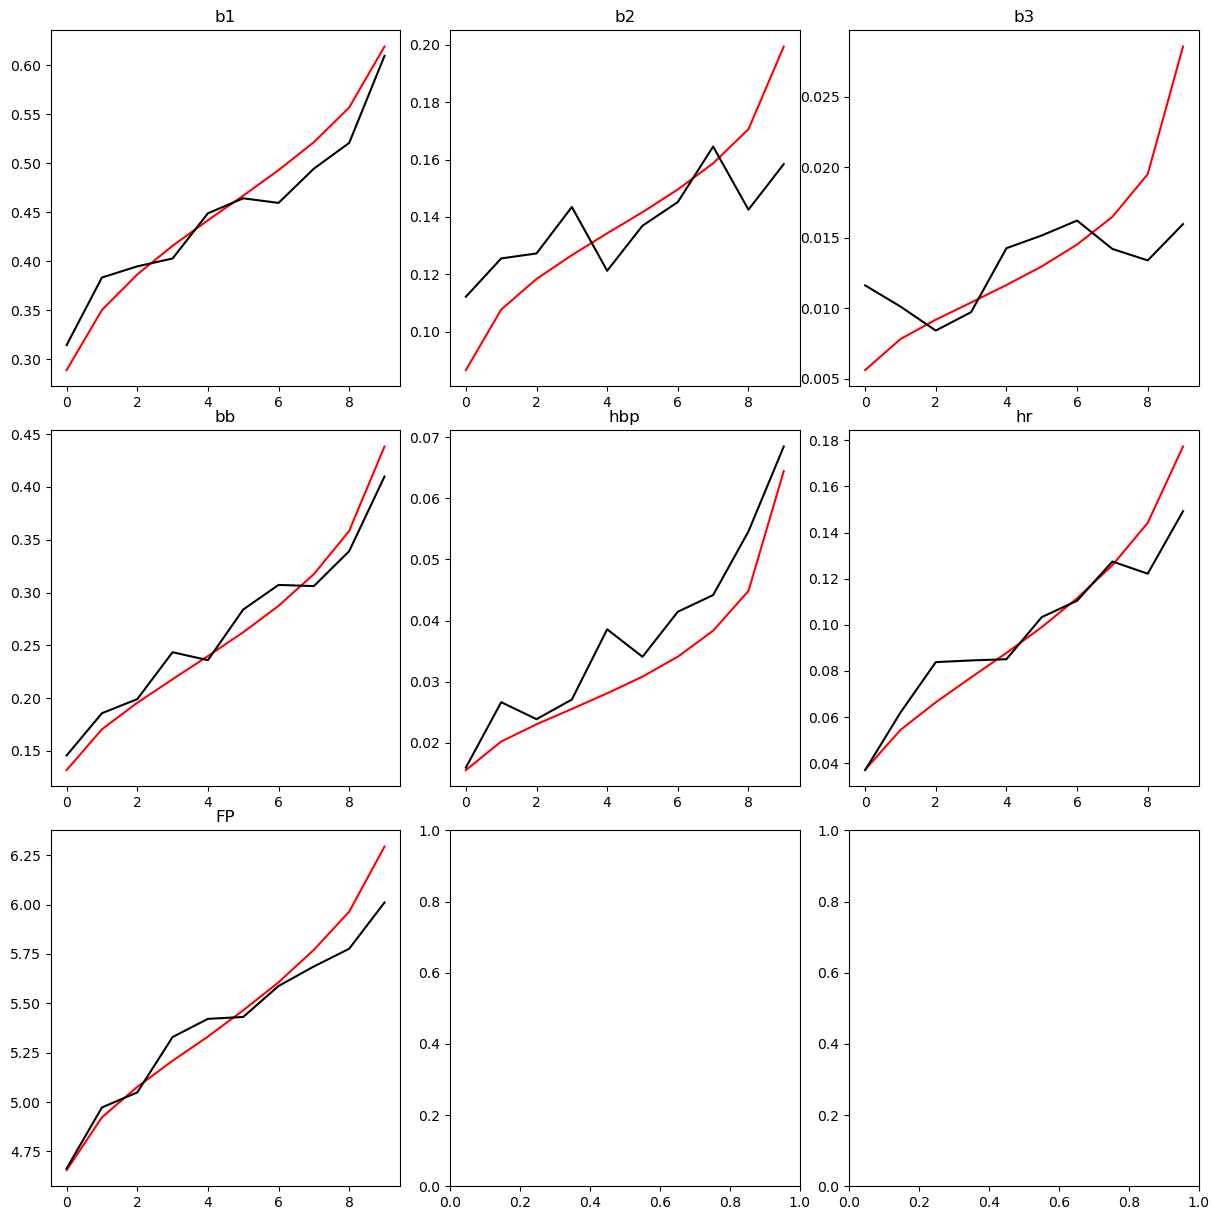

predict_safe_19510_48774_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.448712   1.002207 0.087177 0.000018   
1    All     b2 0.139234  0.145913   0.954223 0.032858 0.000239   
2    All     b3 0.013203  0.013297   0.992961 0.008068 0.000018   
3    All     bb 0.264014  0.258621   1.020852 0.090414 0.000185   
4    All    hbp 0.034034  0.033486   1.016371 0.015305 0.000003   
5    All     hr 0.099813  0.099971   0.998418 0.043075 0.000042   
6    All     FP 5.439955  5.467545   0.994954 0.533433 0.016139   
7   2024     b1 0.453367  0.456144   0.993913 0.086446 0.000147   
8   2024     b2 0.137402  0.144240   0.952591 0.032046 0.000243   
9   2024     b3 0.012906  0.012987   0.993759 0.008182 0.000021   
10  2024     bb 0.262959  0.255321   1.029917 0.087354 0.000402   
11  2024    hbp 0.037444  0.032845   1.140034 0.015367 0.000046   
12  2024     hr 0.095921  0.098463   0.974182 0.041888 0.000214   
13  2024     FP 5.387913

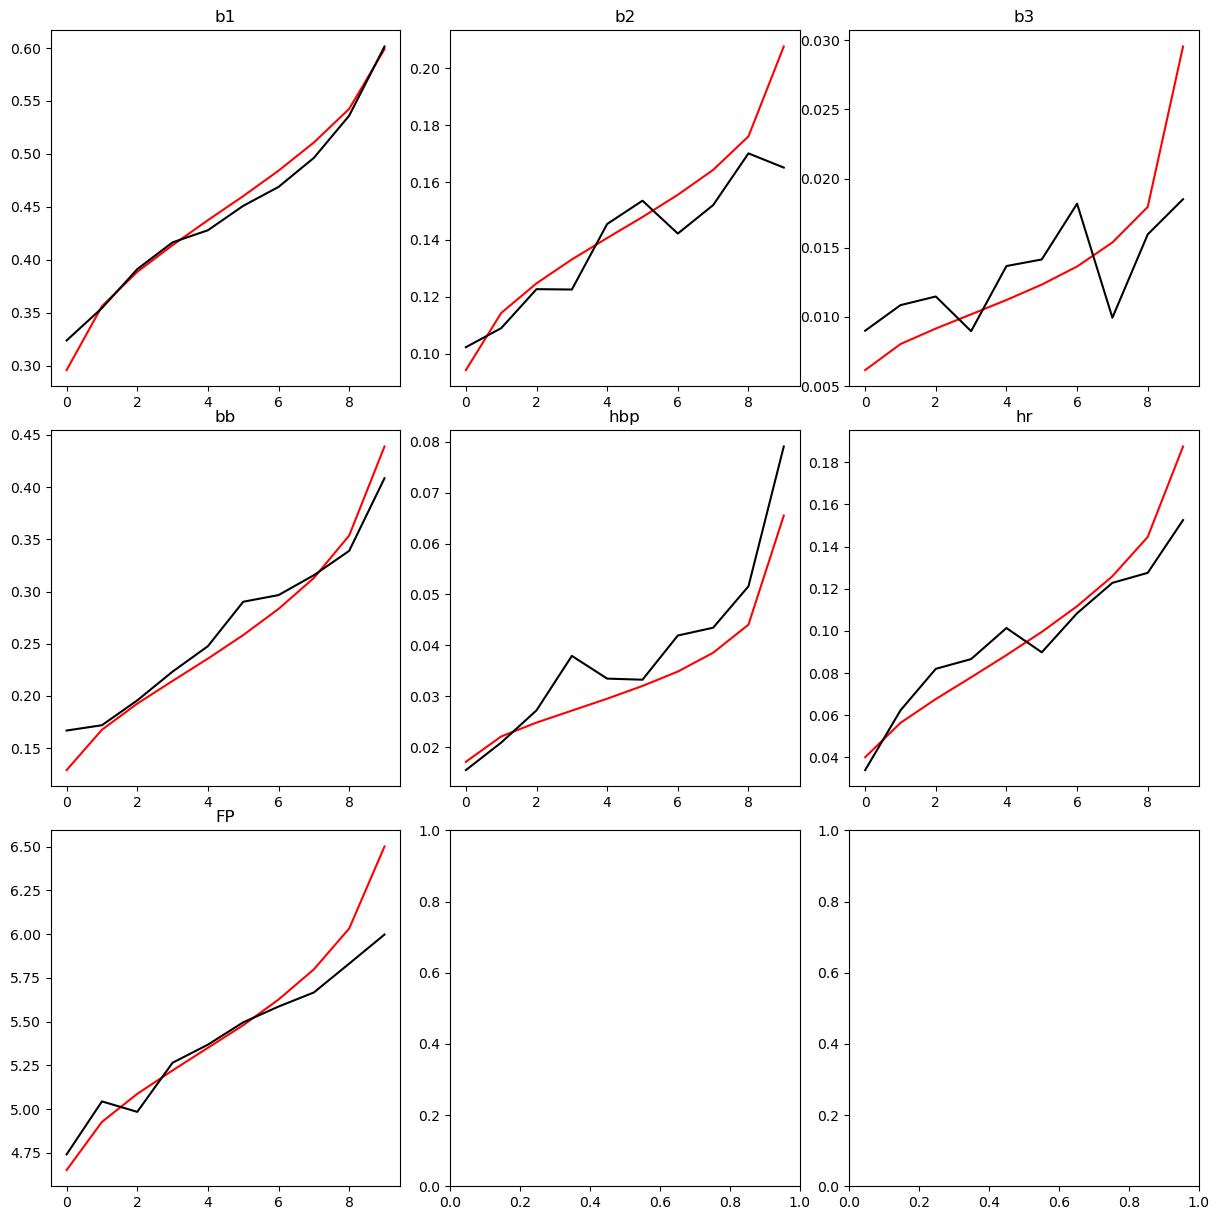

predict_safe_19510_48775_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.461222   0.975022 0.095922 0.000346   
1    All     b2 0.139234  0.139900   0.995241 0.024365 0.000121   
2    All     b3 0.013203  0.014430   0.914969 0.006933 0.000012   
3    All     bb 0.264014  0.250097   1.055644 0.087070 0.000240   
4    All    hbp 0.034034  0.031173   1.091775 0.011716 0.000024   
5    All     hr 0.099813  0.103177   0.967397 0.045828 0.000088   
6    All     FP 5.439955  5.511001   0.987108 0.562593 0.020645   
7   2024     b1 0.453367  0.466444   0.971966 0.094212 0.000561   
8   2024     b2 0.137402  0.141661   0.969934 0.024221 0.000155   
9   2024     b3 0.012906  0.013703   0.941877 0.006581 0.000021   
10  2024     bb 0.262959  0.245837   1.069651 0.084209 0.000423   
11  2024    hbp 0.037444  0.031203   1.200020 0.011442 0.000089   
12  2024     hr 0.095921  0.101153   0.948276 0.044533 0.000356   
13  2024     FP 5.387913

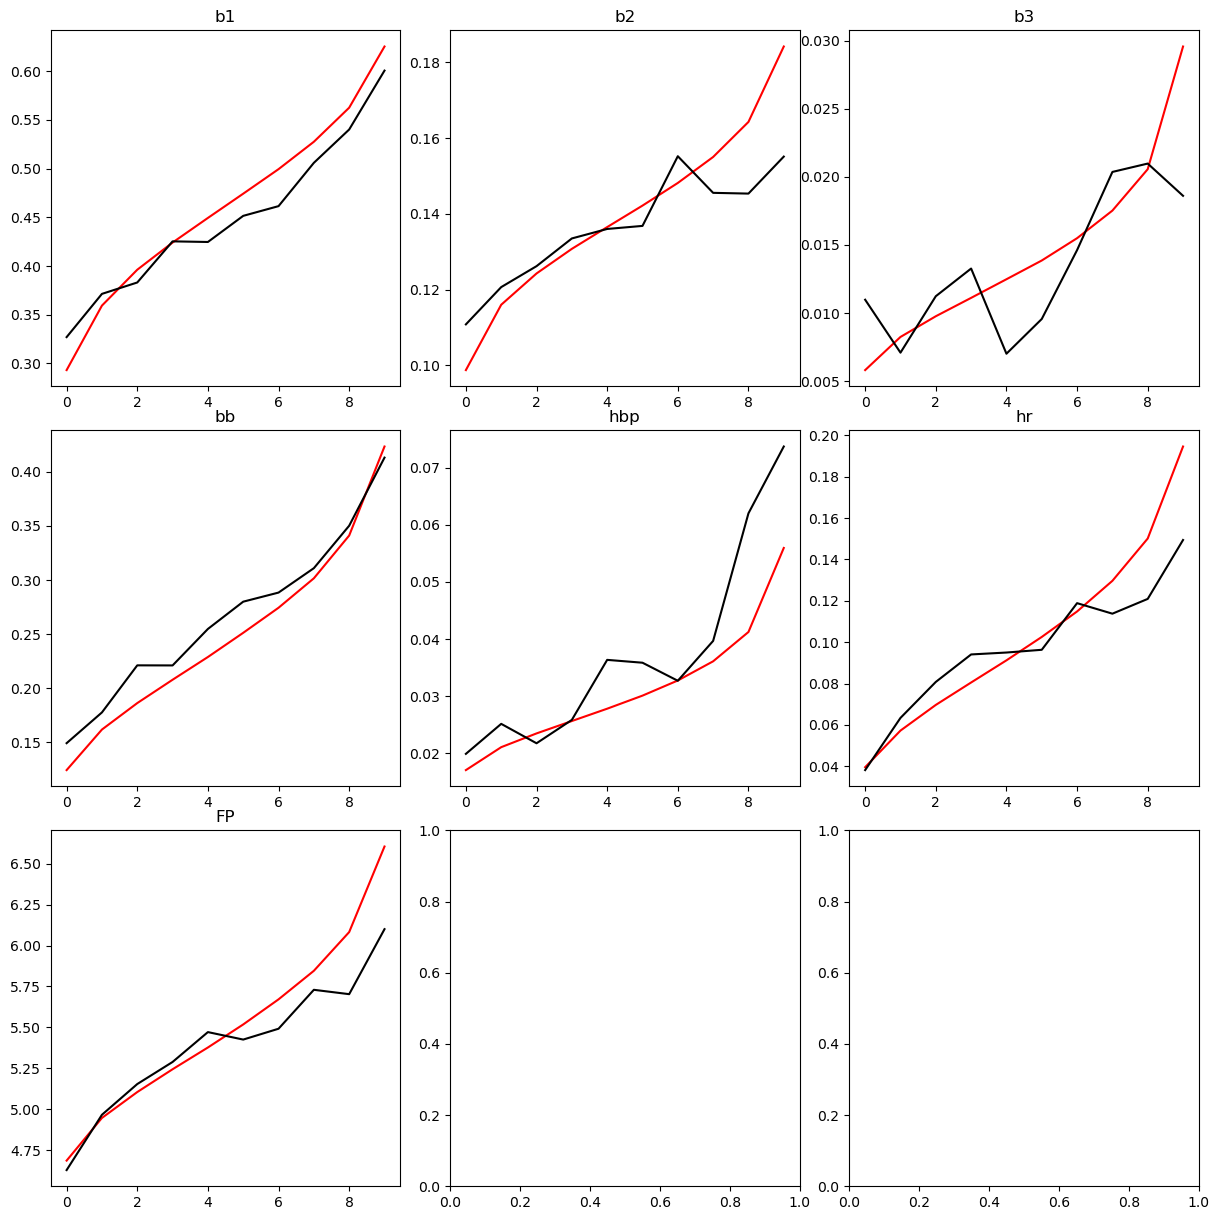

predict_safe_19510_48776_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.457322   0.983338 0.088767 0.000112   
1    All     b2 0.139234  0.136172   1.022488 0.033157 0.000252   
2    All     b3 0.013203  0.012833   1.028802 0.005560 0.000002   
3    All     bb 0.264014  0.262848   1.004437 0.087729 0.000033   
4    All    hbp 0.034034  0.031945   1.065408 0.018123 0.000007   
5    All     hr 0.099813  0.098881   1.009428 0.041760 0.000035   
6    All     FP 5.439955  5.424539   1.002842 0.506337 0.005184   
7   2024     b1 0.453367  0.465116   0.974741 0.085064 0.000230   
8   2024     b2 0.137402  0.135469   1.014269 0.032019 0.000238   
9   2024     b3 0.012906  0.011897   1.084796 0.005473 0.000009   
10  2024     bb 0.262959  0.258567   1.016987 0.085807 0.000230   
11  2024    hbp 0.037444  0.032187   1.163328 0.018532 0.000032   
12  2024     hr 0.095921  0.096764   0.991292 0.040341 0.000289   
13  2024     FP 5.387913

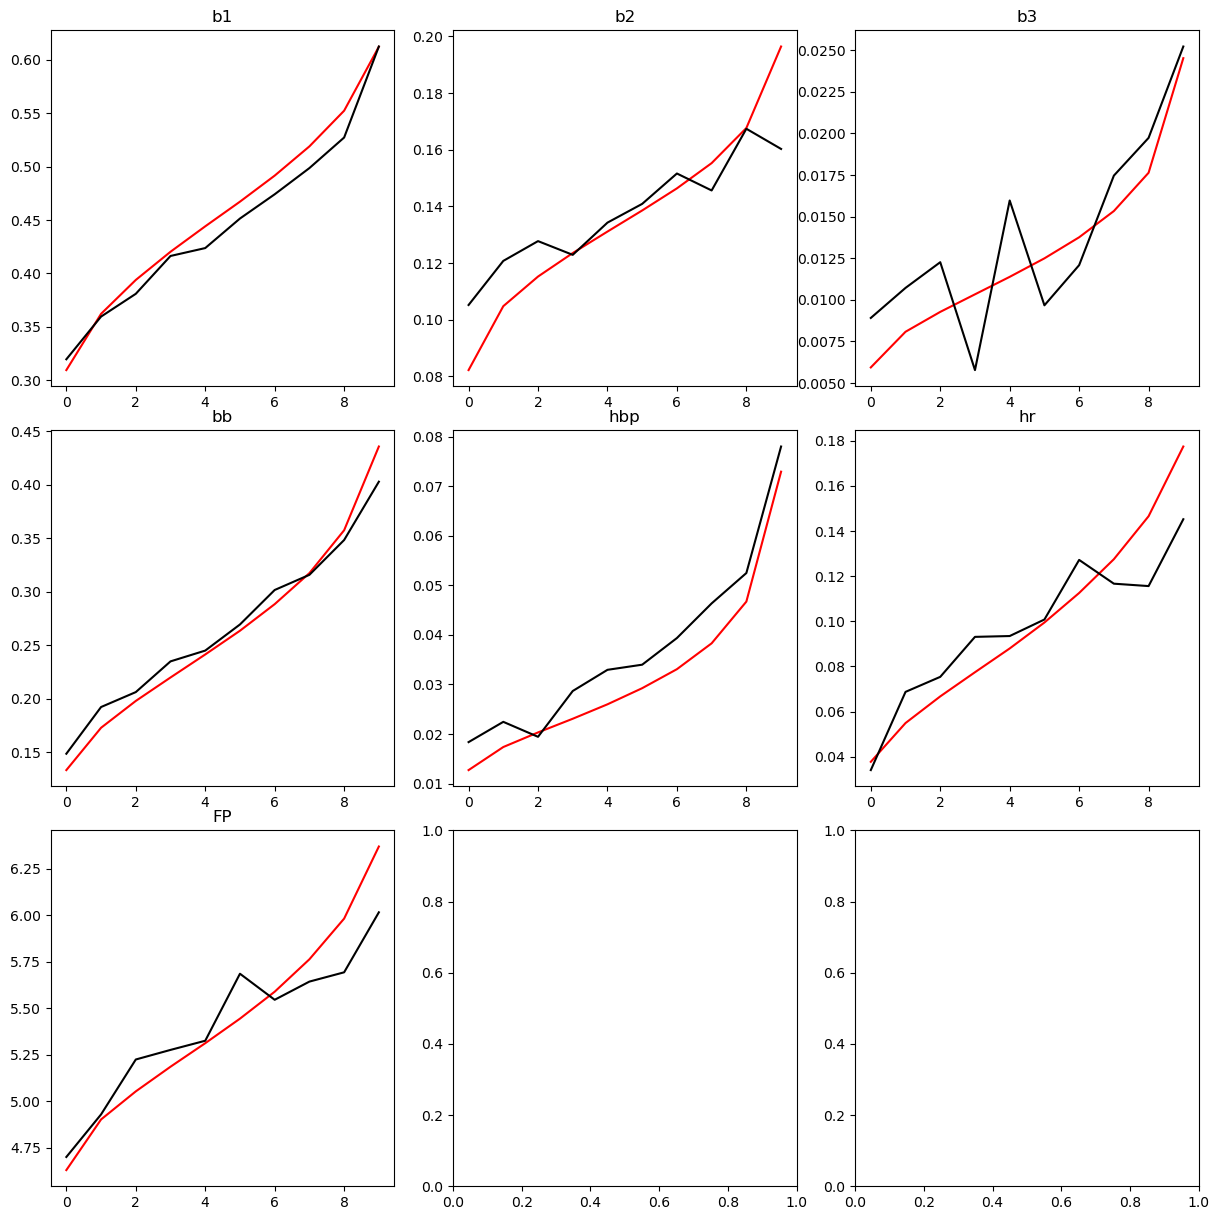

predict_safe_19510_48777_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.451338   0.996375 0.091151 0.000055   
1    All     b2 0.139234  0.137658   1.011449 0.021078 0.000016   
2    All     b3 0.013203  0.013278   0.994327 0.006416 0.000008   
3    All     bb 0.264014  0.268270   0.984134 0.092844 0.000190   
4    All    hbp 0.034034  0.033245   1.023749 0.016324 0.000005   
5    All     hr 0.099813  0.096210   1.037445 0.045884 0.000132   
6    All     FP 5.439955  5.392065   1.008882 0.540922 0.020407   
7   2024     b1 0.453367  0.457577   0.990801 0.088424 0.000325   
8   2024     b2 0.137402  0.136952   1.003282 0.020093 0.000063   
9   2024     b3 0.012906  0.013028   0.990625 0.005968 0.000012   
10  2024     bb 0.262959  0.264756   0.993214 0.088171 0.000352   
11  2024    hbp 0.037444  0.033116   1.130689 0.016618 0.000045   
12  2024     hr 0.095921  0.094570   1.014283 0.043880 0.000240   
13  2024     FP 5.387913

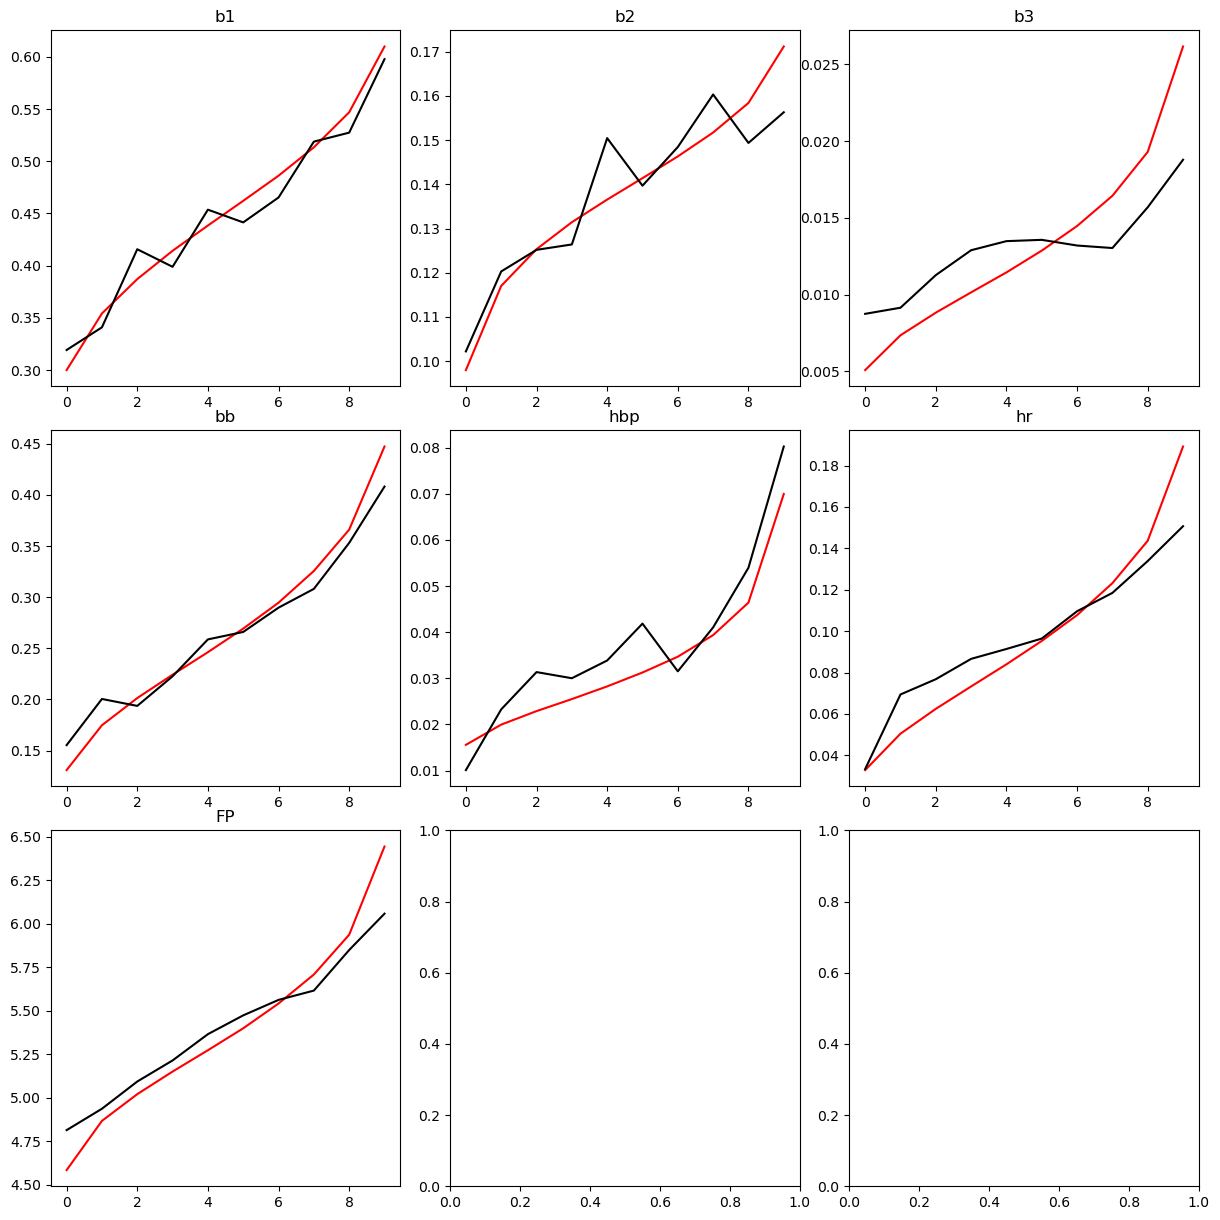

predict_safe_19510_48778_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.439868   1.022355 0.086909 0.000123   
1    All     b2 0.139234  0.138411   1.005945 0.016321 0.000009   
2    All     b3 0.013203  0.012786   1.032616 0.005767 0.000026   
3    All     bb 0.264014  0.276254   0.955691 0.085444 0.000228   
4    All    hbp 0.034034  0.033901   1.003925 0.008659 0.000017   
5    All     hr 0.099813  0.098779   1.010469 0.022759 0.000120   
6    All     FP 5.439955  5.405859   1.006307 0.358063 0.003689   
7   2024     b1 0.453367  0.449049   1.009617 0.084095 0.000217   
8   2024     b2 0.137402  0.137781   0.997251 0.015715 0.000037   
9   2024     b3 0.012906  0.012219   1.056246 0.005377 0.000018   
10  2024     bb 0.262959  0.271600   0.968187 0.082381 0.000415   
11  2024    hbp 0.037444  0.032820   1.140883 0.008227 0.000055   
12  2024     hr 0.095921  0.096532   0.993674 0.021849 0.000053   
13  2024     FP 5.387913

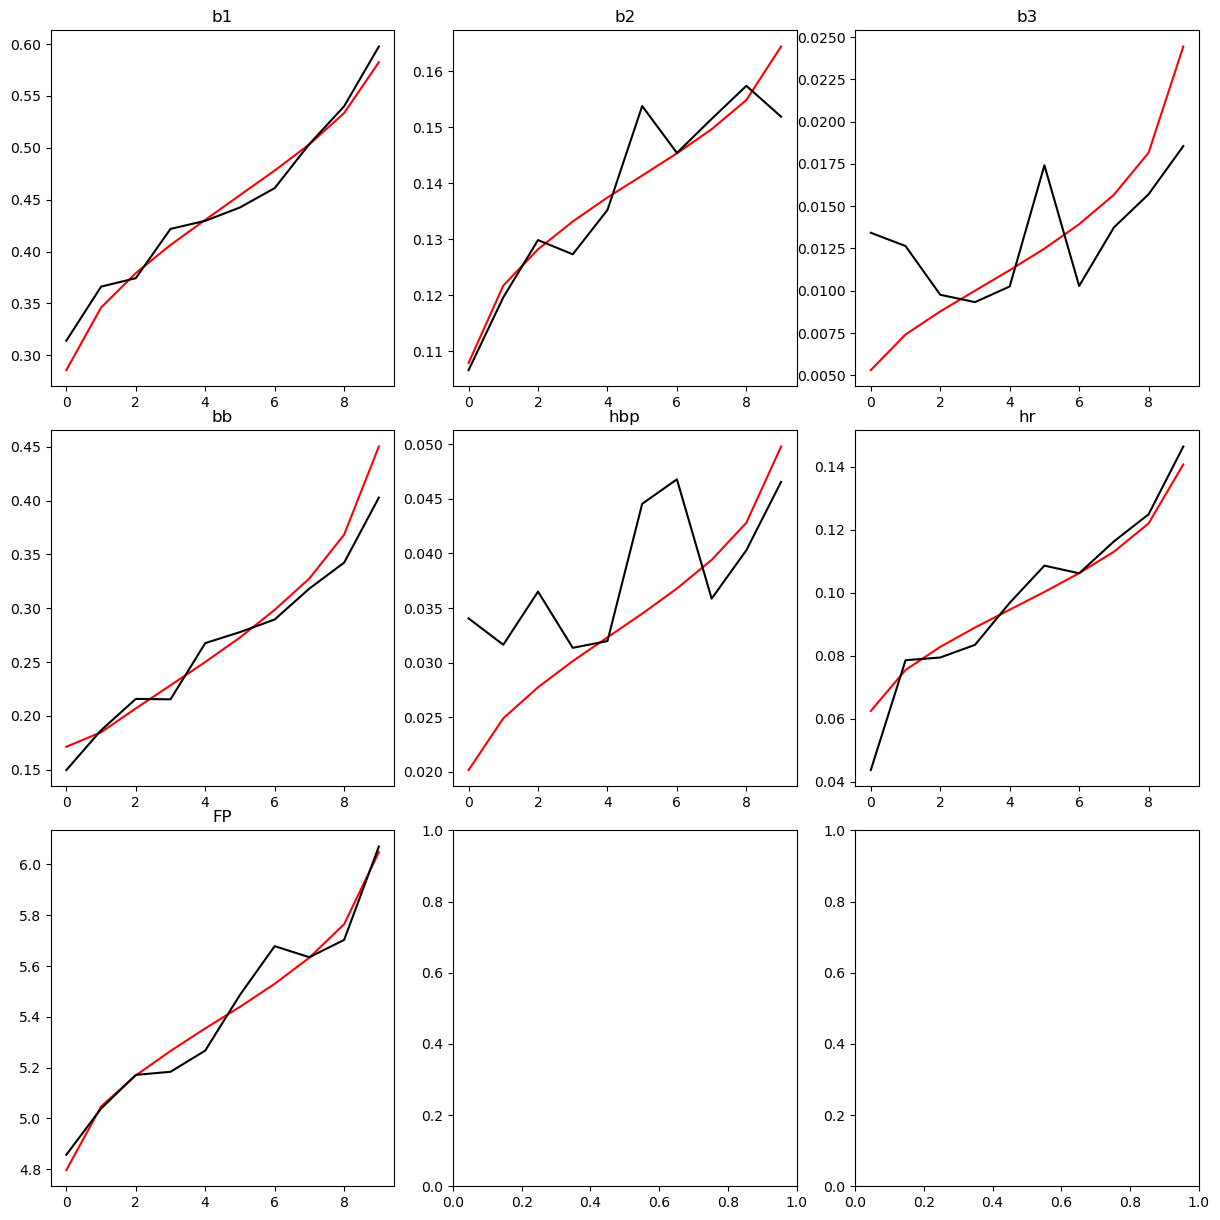

predict_safe_19510_48779_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.445472   1.009495 0.088079 0.000042   
1    All     b2 0.139234  0.140926   0.987994 0.021379 0.000018   
2    All     b3 0.013203  0.013267   0.995193 0.006641 0.000002   
3    All     bb 0.264014  0.266000   0.992532 0.089088 0.000055   
4    All    hbp 0.034034  0.032980   1.031978 0.016822 0.000009   
5    All     hr 0.099813  0.101355   0.984787 0.038910 0.000013   
6    All     FP 5.439955  5.459842   0.996358 0.462600 0.003252   
7   2024     b1 0.453367  0.452604   1.001687 0.085716 0.000192   
8   2024     b2 0.137402  0.140943   0.974876 0.021114 0.000099   
9   2024     b3 0.012906  0.012319   1.047695 0.006279 0.000007   
10  2024     bb 0.262959  0.261183   1.006803 0.085936 0.000223   
11  2024    hbp 0.037444  0.032943   1.136620 0.016572 0.000041   
12  2024     hr 0.095921  0.100008   0.959128 0.037421 0.000178   
13  2024     FP 5.387913

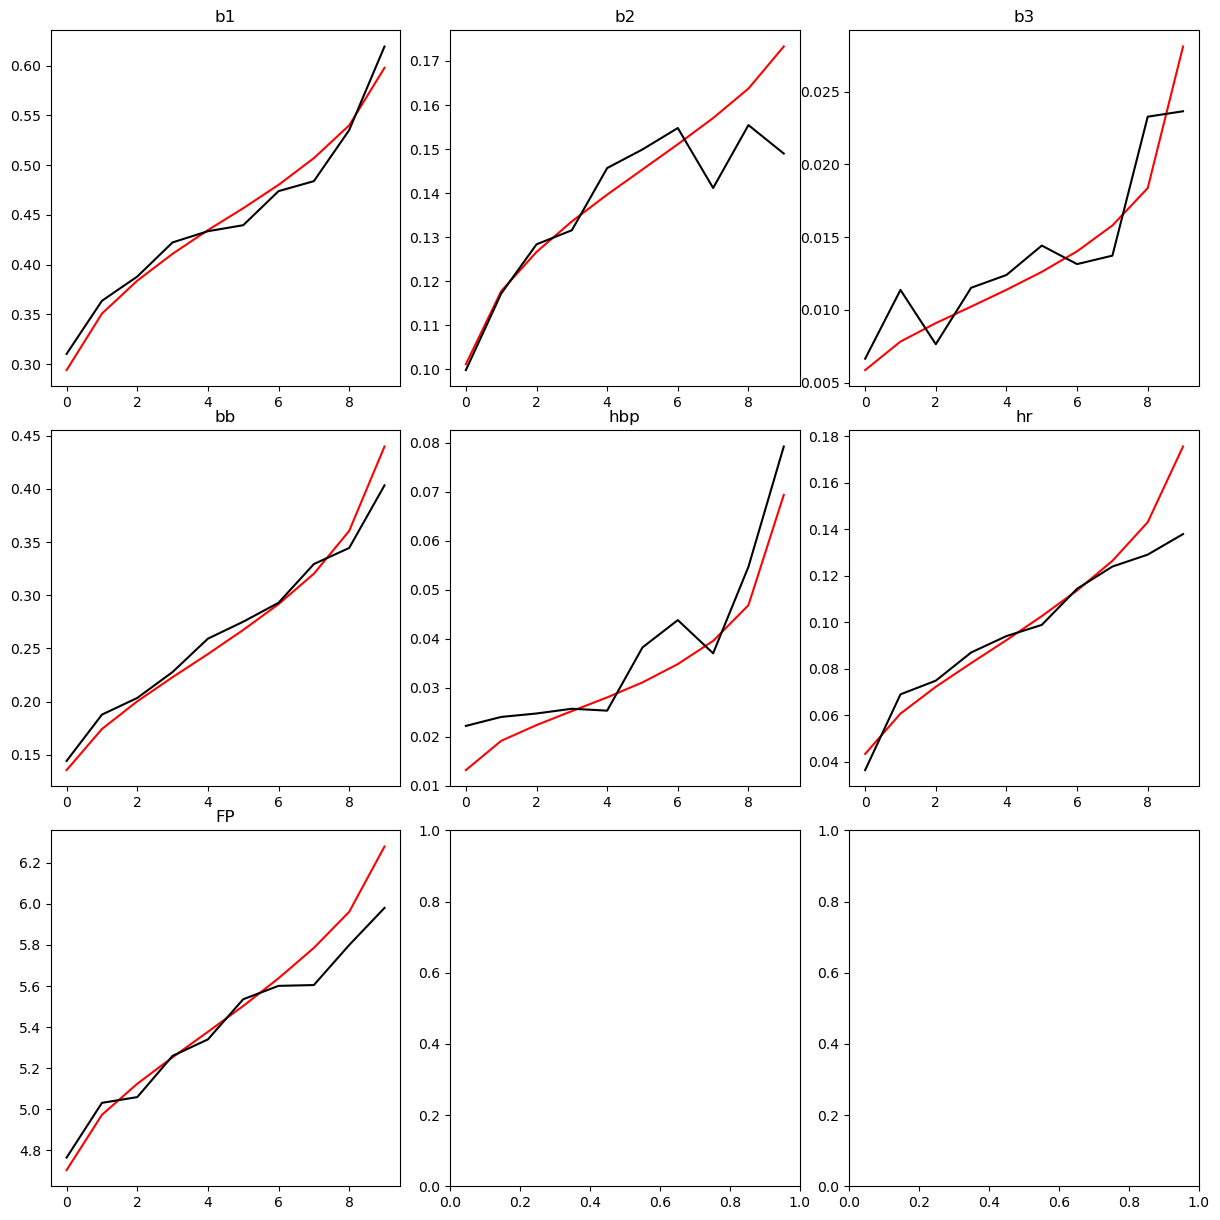

predict_safe_19510_48780_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.459247   0.979216 0.098182 0.000377   
1    All     b2 0.139234  0.140747   0.989253 0.030424 0.000142   
2    All     b3 0.013203  0.012896   1.023782 0.007583 0.000005   
3    All     bb 0.264014  0.257997   1.023322 0.092931 0.000173   
4    All    hbp 0.034034  0.031569   1.078084 0.016544 0.000010   
5    All     hr 0.099813  0.097544   1.023260 0.041856 0.000028   
6    All     FP 5.439955  5.429417   1.001941 0.494022 0.004380   
7   2024     b1 0.453367  0.466732   0.971365 0.096023 0.000640   
8   2024     b2 0.137402  0.139241   0.986790 0.029327 0.000150   
9   2024     b3 0.012906  0.012539   1.029325 0.007516 0.000017   
10  2024     bb 0.262959  0.253925   1.035580 0.090665 0.000417   
11  2024    hbp 0.037444  0.030827   1.214644 0.016767 0.000067   
12  2024     hr 0.095921  0.096736   0.991573 0.040680 0.000211   
13  2024     FP 5.387913

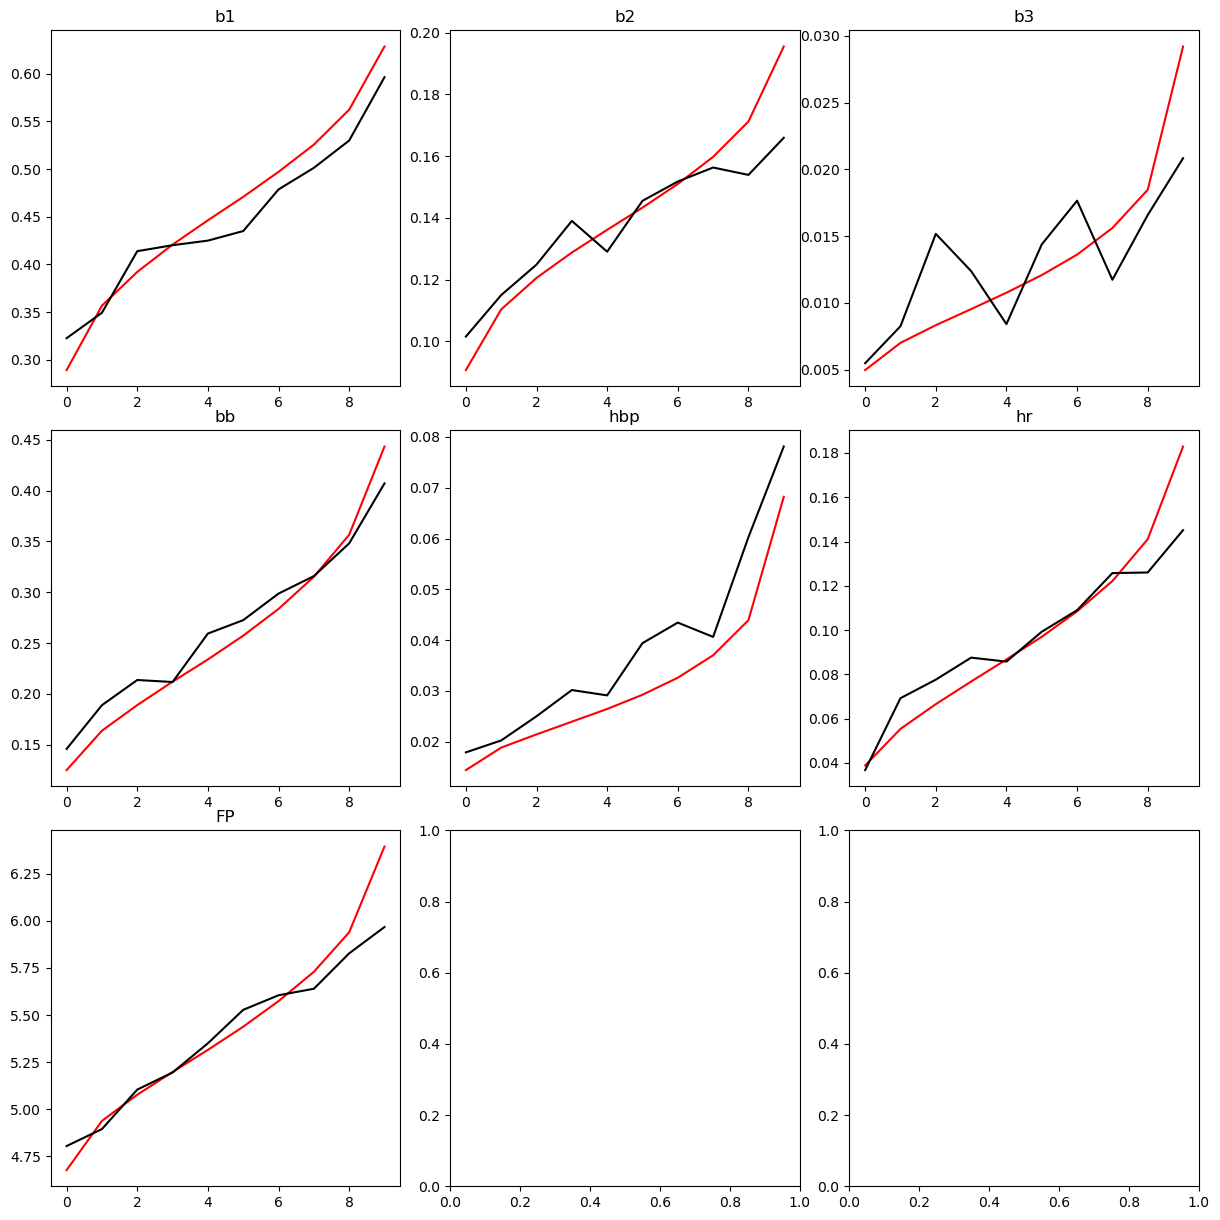

predict_safe_19510_48781_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.455690   0.986859 0.096110 0.000154   
1    All     b2 0.139234  0.144313   0.964807 0.021023 0.000037   
2    All     b3 0.013203  0.013950   0.946463 0.006267 0.000012   
3    All     bb 0.264014  0.252029   1.047555 0.093127 0.000243   
4    All    hbp 0.034034  0.032519   1.046600 0.015738 0.000005   
5    All     hr 0.099813  0.101499   0.983384 0.043897 0.000042   
6    All     FP 5.439955  5.495700   0.989857 0.544272 0.011602   
7   2024     b1 0.453367  0.464122   0.976827 0.092303 0.000336   
8   2024     b2 0.137402  0.143615   0.956734 0.019886 0.000156   
9   2024     b3 0.012906  0.013499   0.956098 0.005909 0.000019   
10  2024     bb 0.262959  0.248784   1.056977 0.088358 0.000522   
11  2024    hbp 0.037444  0.031869   1.174945 0.015528 0.000046   
12  2024     hr 0.095921  0.098110   0.977691 0.041581 0.000177   
13  2024     FP 5.387913

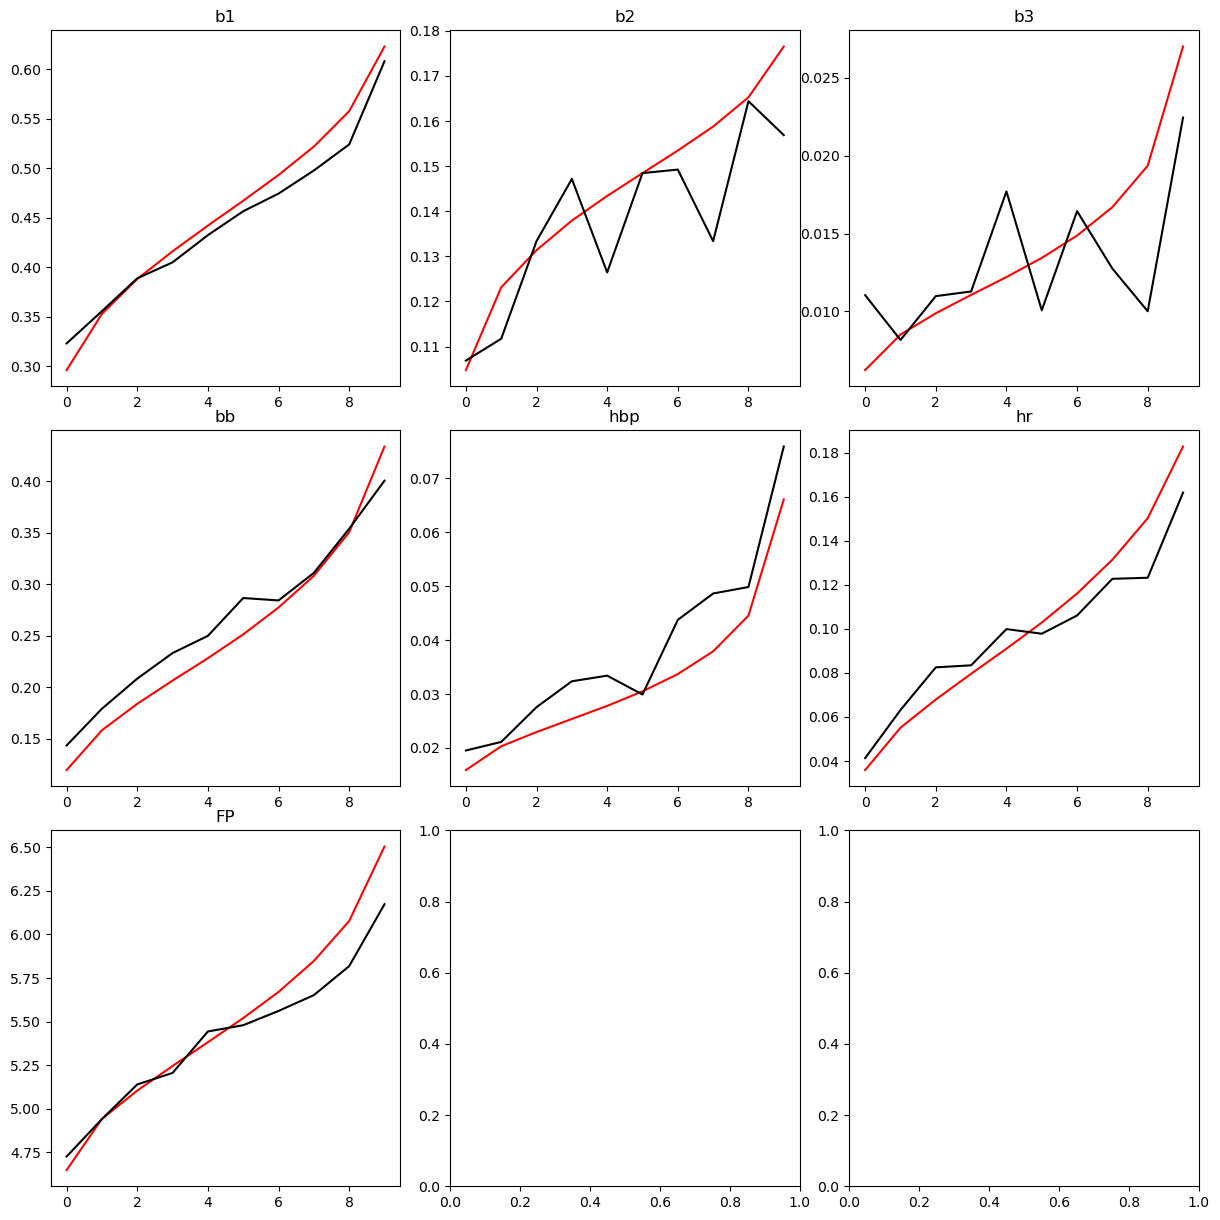

predict_safe_19510_48782_20250304.sav
    Year Output   Actual Predicted Multiplier Std. Dev      MSE  \
0    All     b1 0.449702  0.457707   0.982510 0.093642 0.000193   
1    All     b2 0.139234  0.137704   1.011109 0.029890 0.000165   
2    All     b3 0.013203  0.013439   0.982443 0.005896 0.000006   
3    All     bb 0.264014  0.261763   1.008598 0.090913 0.000098   
4    All    hbp 0.034034  0.034787   0.978345 0.017121 0.000004   
5    All     hr 0.099813  0.094599   1.055118 0.043195 0.000073   
6    All     FP 5.439955  5.383221   1.010539 0.529551 0.014883   
7   2024     b1 0.453367  0.464979   0.975028 0.090979 0.000406   
8   2024     b2 0.137402  0.136282   1.008218 0.029239 0.000269   
9   2024     b3 0.012906  0.013341   0.967434 0.005759 0.000011   
10  2024     bb 0.262959  0.258019   1.019146 0.087117 0.000302   
11  2024    hbp 0.037444  0.034916   1.072399 0.017542 0.000031   
12  2024     hr 0.095921  0.092463   1.037400 0.040775 0.000241   
13  2024     FP 5.387913

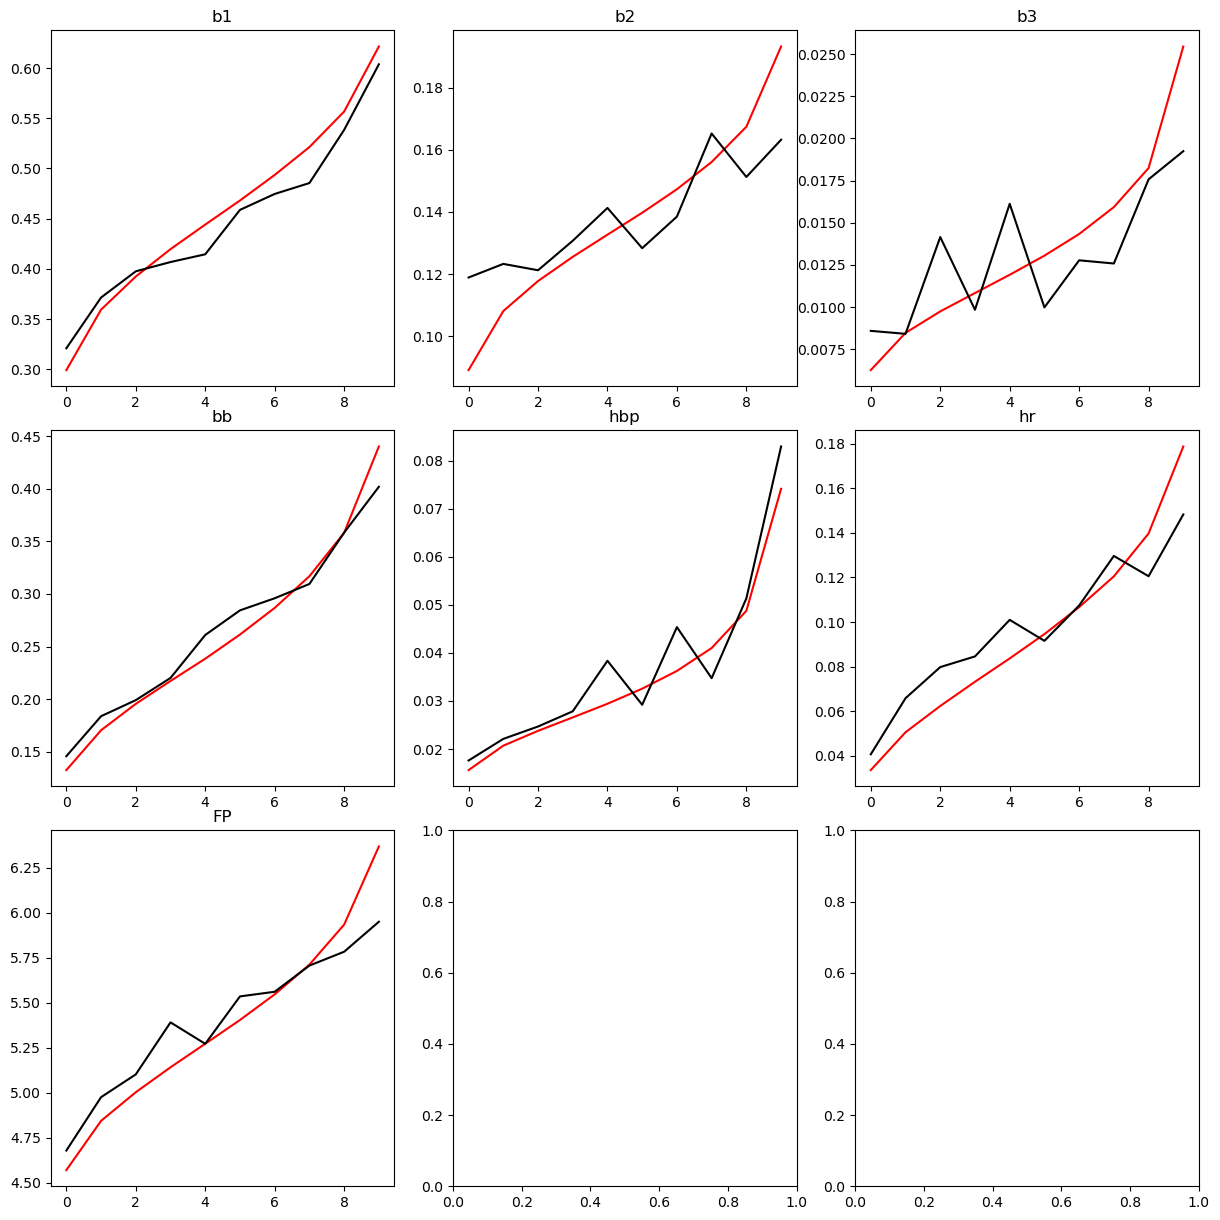

predict_safe_19510_48783_20250304.sav



KeyboardInterrupt



In [71]:
%%time
for i in range(num_models):
    # Set filename
    safe_filename = f"predict_safe_{layers_str}_{random_state+i}_{todaysdate}.sav"
    print(safe_filename)

    # Create Model
    predict_safe = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=False, alpha=alpha, learning_rate_init=learning_rate, 
                                 early_stopping=True, random_state=random_state+i, max_iter=max_iter, batch_size=batch_size)

    # Fit
    predict_safe.fit(model_dataset[training_mask][~out_mask][input_list], model_dataset[training_mask][~out_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_safe, open(os.path.join(model_path, "M03. Plate Appearances", safe_filename), 'wb'))

    # Predict 
    safe_outputs = list(predict_safe.classes_)
    safe_outputs_pred = [x + "_pred" for x in safe_outputs]
    
    model_dataset.loc[~training_mask & ~out_mask, safe_outputs_pred] = predict_safe.predict_proba(model_dataset[~training_mask][~out_mask][input_list])

    # FP
    model_dataset.loc[~training_mask & ~out_mask, 'FP_act'] = (
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "b1").astype(int)  *  4.3665 +
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "b2").astype(int)  *  6.8271 +
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "b3").astype(int)  * 10.8503 +
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "hr").astype(int)  * 15.2611 +
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "bb").astype(int)  *  2.8725 +
                                 (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == "hbp").astype(int) *  2.9639
                                 )

    model_dataset.loc[~training_mask & ~out_mask, 'FP_pred'] = (model_dataset[~training_mask][~out_mask]['b1_pred']  *  4.3665 +
                                                                model_dataset[~training_mask][~out_mask]['b2_pred']  *  6.8271 +
                                                                model_dataset[~training_mask][~out_mask]['b3_pred']  * 10.8503 + 
                                                                model_dataset[~training_mask][~out_mask]['hr_pred']  * 15.2611 +
                                                                model_dataset[~training_mask][~out_mask]['bb_pred']  *  2.8725 +
                                                                model_dataset[~training_mask][~out_mask]['hbp_pred'] *  2.9639
                                                               )

    # Quantiles
    year = 2024
    venue = 19
    
    for var in safe_outputs:
        # Create actual outcome column
        model_dataset.loc[~training_mask & ~out_mask, f'{var}_act'] = (model_dataset.loc[~training_mask & ~out_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask & ~out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & ~out_mask, f'{var}_pred'], 10, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    for var in ['FP']:
        # Create deciles
        model_dataset.loc[~training_mask & ~out_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask & ~out_mask, f'{var}_pred'], 10, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask & ~out_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

    # All
    all_df_list = []
    for var in safe_outputs + ['FP']:
        actual = model_dataset.loc[~training_mask & ~out_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask & ~out_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask & ~out_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    # Year
    recent_df_list = []
    for var in safe_outputs + ['FP']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask & ~out_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask & ~out_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask & ~out_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    # DataFrame
    safe_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    safe_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    safe_stat_df['File'] = safe_filename
    safe_stat_df['Layers'] = str(layers)
    safe_stat_df['Models'] = num_models
    safe_stat_df['State'] = random_state+i
    safe_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(safe_stat_df)
    
    safe_stat_list.append(safe_stat_df)
    
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")
    
    # Create figures
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    for i, var in enumerate(safe_outputs + ['FP']):
        row = i // 3  # Calculate the row index based on the iteration
        col = i % 3   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
        # axs[row, col].set_ylim(0,0.35)
    
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

##### Evaluate

Create evaluations dataframe

In [72]:
all_safe_stat_df = pd.concat(safe_stat_list)
all_safe_stat_df = all_safe_stat_df.reset_index(drop=True)

Identify pareto-optimal models

In [74]:
subset = all_safe_stat_df.query('Year == "2024"').query('Output == "FP"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,File,Layers,Models,State
10,2024,FP,5.387913,5.384618,1.000612,0.343532,0.004659,predict_safe_19510_48778_20250304.sav,"(195, 10)",20,48778
0,2024,FP,5.387913,5.434983,0.991339,0.357162,0.006918,predict_safe_195105_28031_20250304.sav,"(195, 10, 5)",20,28031
5,2024,FP,5.387913,5.414712,0.995051,0.438416,0.009954,predict_safe_19510_48770_20250304.sav,"(195, 10)",20,48770
7,2024,FP,5.387913,5.421218,0.993856,0.469115,0.014996,predict_safe_19510_48773_20250304.sav,"(195, 10)",20,48773
3,2024,FP,5.387913,5.379184,1.001623,0.492689,0.016092,predict_safe_19510_48766_20250304.sav,"(195, 10)",20,48766
9,2024,FP,5.387913,5.376269,1.002166,0.513337,0.024681,predict_safe_19510_48777_20250304.sav,"(195, 10)",20,48777
6,2024,FP,5.387913,5.431236,0.992023,0.540627,0.032673,predict_safe_19510_48772_20250304.sav,"(195, 10)",20,48772
